In [1]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Datasets

**Validation dataset:**
* Used for hyperparameter tunning
* When you train a model on the training set, it can memorize noise instead of learning general patterns.  
* Monitoring performance on a validation set tells you when your model is starting to overfit.
* Use 10–20% of your data for validation when you have thousands of samples.
* For small datasets, apply k-fold cross-validation to rotate through multiple validation and training splits.
* Ensure your validation set reflects the same distribution as your training and test sets.  

**Large datasets (10 000 <):**
* 80% training
* 10% validation
* 10% test

**Small datasets (1000 >):**
* 80% training/validation (k-fold splits)
* 20% test

## AI job

In [2]:
ai_job = pd.read_csv('/kaggle/input/global-ai-job-market-trend-2025/ai_job_dataset.csv')

salary = {}
for position in ai_job.job_title.unique():
    pos = ai_job.query('job_title == @position and salary_currency == "USD"')
    salary[position] = int(pos.salary_usd.mean())

salary = dict(sorted(salary.items(), key=lambda item: item[1], reverse=True))
salary

{'AI Specialist': 118618,
 'Head of AI': 117012,
 'AI Research Scientist': 116257,
 'ML Ops Engineer': 115754,
 'AI Architect': 115662,
 'Machine Learning Engineer': 114346,
 'Deep Learning Engineer': 113821,
 'Robotics Engineer': 113736,
 'Research Scientist': 113579,
 'AI Product Manager': 113509,
 'Data Engineer': 113436,
 'Principal Data Scientist': 113329,
 'Data Scientist': 113323,
 'AI Software Engineer': 113028,
 'Computer Vision Engineer': 112634,
 'AI Consultant': 112497,
 'Data Analyst': 110374,
 'NLP Engineer': 110361,
 'Machine Learning Researcher': 109405,
 'Autonomous Systems Engineer': 108889}

In [3]:
ai_job_future = pd.read_csv('/kaggle/input/ai-impact-on-job-market-20242030/ai_job_trends_dataset.csv')
ai_job_future['opening_difference'] = ai_job_future['Projected Openings (2030)'] - ai_job_future['Job Openings (2024)']
ai_job_future_it = ai_job_future.query('Industry == "IT"')
ai_job_future_it[['Job Title', 'opening_difference', 'Job Status', 'Automation Risk (%)', 'AI Impact Level', 'Industry']].sort_values(by='opening_difference', ascending=True)

Job Title  opening_difference  Job Status  \
10775               Quality manager               -9693  Increasing   
22995                Pilot, airline               -9622  Increasing   
13779         Clinical psychologist               -9511  Decreasing   
17016  Research officer, government               -9432  Increasing   
25211    Lecturer, higher education               -9420  Increasing   
...                             ...                 ...         ...   
21447         Editor, commissioning                9492  Increasing   
21048  Designer, industrial/product                9510  Decreasing   
3673                        Midwife                9562  Decreasing   
18242   Corporate investment banker                9744  Increasing   
1149       Technical sales engineer                9799  Increasing   

       Automation Risk (%) AI Impact Level Industry  
10775                88.95             Low       IT  
22995                36.89        Moderate       IT  
13779                73.72        Moderate       IT  
17016                40.03             Low       IT  
25211                86.15             Low       IT  
...                    ...             ...      ...  
21447                62.90             Low       IT  
21048                29.82            High       IT  
3673                 50.45        Moderate       IT  
18242                 4.93        Moderate       IT  
1149                 10.25            High       IT  

[3681 rows x 6 columns]

## Pubg data

In [2]:
# load data
train_data = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/train_V2.csv')
test_data = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/test_V2.csv')

X = train_data.drop('winPlacePerc', axis=1)
Y = train_data['winPlacePerc']

In [3]:
with pd.option_context('display.max_columns', None):
    display(train_data)

Id         groupId         matchId  assists  boosts  \
0        7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1        eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2        1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3        4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4        315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   
...                 ...             ...             ...      ...     ...   
4446961  afff7f652dbc10  d238e426f50de7  18492834ce5635        0       0   
4446962  f4197cf374e6c0  408cdb5c46b2ac  ee854b837376d9        0       1   
4446963  e1948b1295c88a  e26ac84bdf7cef  6d0cd12784f1ab        0       0   
4446964  cc032cdd73b7ac  c2223f35411394  c9c701d0ad758a        0       4   
4446965  0d8e7ed728b6fd  8c74f72fedf5ff  62a16aabcc095c        0       2   

         damageDealt  DBNOs  headshotKills  heals  killPlace  killPoints  \
0               0.00      0              0      0         60        1241   
1              91.47      0              0      0         57           0   
2              68.00      0              0      0         47           0   
3              32.90      0              0      0         75           0   
4             100.00      0              0      0         45           0   
...              ...    ...            ...    ...        ...         ...   
4446961         0.00      0              0      0         74        1029   
4446962        44.15      0              0      0         69           0   
4446963        59.06      0              0      0         66           0   
4446964       180.40      1              1      2         11           0   
4446965       268.00      0              0      1         18           0   

         kills  killStreaks  longestKill  matchDuration  matchType  maxPlace  \
0            0            0         0.00           1306  squad-fpp        28   
1            0            0         0.00           1777  squad-fpp        26   
2            0            0         0.00           1318        duo        50   
3            0            0         0.00           1436  squad-fpp        31   
4            1            1        58.53           1424   solo-fpp        97   
...        ...          ...          ...            ...        ...       ...   
4446961      0            0         0.00           1873  squad-fpp        29   
4446962      0            0         0.00           1435       solo        93   
4446963      0            0         0.00           1321  squad-fpp        28   
4446964      2            1        98.50           1373  squad-fpp        26   
4446965      2            1        78.25           1766   solo-fpp        98   

         numGroups  rankPoints  revives  rideDistance  roadKills  \
0               26          -1        0        0.0000          0   
1               25        1484        0        0.0045          0   
2               47        1491        0        0.0000          0   
3               30        1408        0        0.0000          0   
4               95        1560        0        0.0000          0   
...            ...         ...      ...           ...        ...   
4446961         28          -1        0     1292.0000          0   
4446962         93        1501        0        0.0000          0   
4446963         28        1500        0        0.0000          0   
4446964         25        1418        2        0.0000          0   
4446965         94        1590        0     1369.0000          0   

         swimDistance  teamKills  vehicleDestroys  walkDistance  \
0               0.000          0                0        244.80   
1              11.040          0                0       1434.00   
2               0.000          0                0        161.80   
3               0.000          0                0        202.70   
4               0.000          0                0         49.75   
...            

# EDA

| **Step**                      | **What to Do**                                                                                                                           | **Why It Matters**                                     | **Tip / Tools**                                                            |
| ----------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------ | -------------------------------------------------------------------------- |
| **1. Initial Inspection**     | • Check shape, dtypes, head/tail<br>• Summary stats (mean, median, std, unique counts)                                                   | Understand data structure and spot anomalies early     | `df.info()`, `df.head()`, `df.describe()`                                  |
| **2. Data Quality Check**     | • Detect duplicates<br>• Identify missing values and encoding issues<br>• Find inconsistencies                                           | Avoid skewed analysis due to poor data                 | `df.duplicated()`, `df.isnull()`, `missingno`                              |
| **3. Univariate Exploration** | • Plot histograms/density for numeric<br>• Box plots for outliers<br>• Bar charts for categories                                         | Reveal distributions, skewness, and anomalies          | `sns.histplot()`, `sns.boxplot()`, `df.value_counts()`                     |
| **4. Bivariate Analysis**     | • Scatter/pair plots for numeric<br>• Heatmap of correlations<br>• Countplots for category combos                                        | Uncover relationships and multicollinearity            | `sns.scatterplot()`, `sns.heatmap()`, `sns.countplot()`                    |
| **5. Missing & Outliers**     | • Heatmap/matrix for missingness<br>• Box/violin plots for continuous outliers                                                           | Guides decisions on cleaning and transformations       | `missingno.matrix()`, `sns.violinplot()`                                   |
| **6. Data Cleaning**          | • Impute or drop missing values<br>• Remove duplicates<br>• Standardize formats & resolve inconsistencies<br>• Detect and treat outliers | Prepares data for reliable modeling                    | `SimpleImputer`, `df.drop_duplicates()`, `df.fillna()`, `z‑score` or `IQR` |
| **7. Transform & Encode**     | • Scale numeric (standard/min–max)<br>• Encode categoricals (one-hot, label, ordinal)<br>• Convert types (date, category)                | Ensures features are compatible with model assumptions | `StandardScaler`, `MinMaxScaler`, `pd.get_dummies()`                       |
| **8. Feature Engineering**    | • Create features (ratios, datetime parts)<br>• Drop redundant features (via correlation/domain knowledge)                               | Boosts model performance and reduces noise             | `df.corr()`, predicate logic, domain expertise                             |
| **9. Document & Iterate**     | • Log all transformations & decisions<br>• Revisit steps based on new findings                                                           | Promotes reproducibility and ensures thoroughness      | Code comments, data notebooks, changelogs                                  |


**Your Final Outcome:**

By the end of **EDA**, you should have:

* A comprehensive understanding of your data's quality, structure, and characteristics. 
* Clear documentation of data issues and their potential impacts. 
* A preprocessing strategy based on your findings. 
* Initial hypotheses about which features might be most important. 
* A sense of what modeling approaches might work best given your data's properties.

*The key insight is that EDA isn't just about checking boxes - it's about building intuition that will guide every subsequent decision in your machine learning pipeline. The distribution analysis is just the foundation for this deeper understanding.*

## Initial inspection

In [13]:
train_data.head()

Id         groupId         matchId  assists  boosts  \
0  7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1  eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2  1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3  4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4  315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   

   damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
0         0.00      0              0      0         60  ...        0   
1        91.47      0              0      0         57  ...        0   
2        68.00      0              0      0         47  ...        0   
3        32.90      0              0      0         75  ...        0   
4       100.00      0              0      0         45  ...        0   

   rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
0        0.0000          0          0.00          0               0   
1        0.0045          0         11.04          0               0   
2        0.0000          0          0.00          0               0   
3        0.0000          0          0.00          0               0   
4        0.0000          0          0.00          0               0   

   walkDistance  weaponsAcquired  winPoints  winPlacePerc  
0        244.80                1       1466        0.4444  
1       1434.00                5          0        0.6400  
2        161.80                2          0        0.7755  
3        202.70                3          0        0.1667  
4         49.75                2          0        0.1875  

[5 rows x 29 columns]

In [ ]:
display(train_data.info())
display(train_data.describe())

## Checking data quality

In [ ]:
# Duplicates
train_data.duplicated('Id').value_counts()

In [ ]:
# Nans
display(train_data.isna().sum())

## Univariant exploration

**Why Check Data Distribution?**

* Understanding the nature of your data: Is it normally distributed, skewed, bimodal? This tells you about the underlying processes that generated your data and helps you choose appropriate modeling techniques.

* Identifying potential issues: Extreme skewness, unexpected peaks, or gaps in the distribution can signal data quality problems, measurement errors, or important business insights.

* Informing preprocessing decisions: The distribution shape directly impacts what transformations or scaling methods you'll need later.

**What Should Alarm You?**

* Extreme skewness: If your data is heavily skewed, many machine learning algorithms will struggle. Linear regression, for example, assumes normally distributed residuals.

* Unexpected modes: Multiple peaks might indicate your data actually represents different populations that should be analyzed separately.

* Impossible values - Negative ages, dates in the future, or values outside expected ranges suggest data quality issues.

* Too many zeros or missing patterns - This might indicate systematic data collection problems or business rules you need to understand.

**Should You Fix It Immediately?**

Not necessarily. During EDA, your primary goal is to **understand and document** what you're seeing. Don't rush to transform data until you understand why it looks the way it does. Sometimes what appears to be a "problem" is actually valuable information about your domain.

However, you should definitely code up your observations and potential solutions for later use.

### Target data

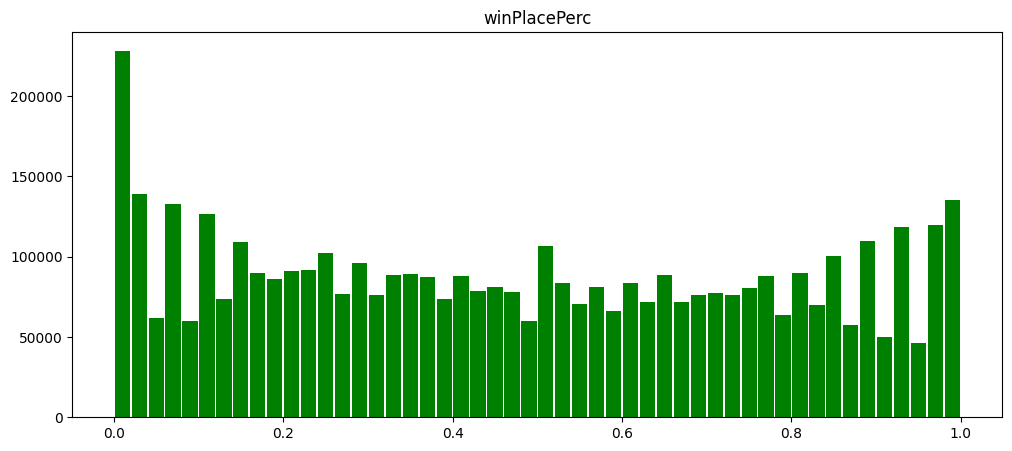

In [4]:
# check how our target data looks like

plt.figure(figsize=(12,5))
plt.hist(train_data['winPlacePerc'], bins=50, color='green', rwidth=0.90)
plt.title("winPlacePerc")
plt.show()

### Data Visualization

std: 0.9824372680299405, mean: 0.0013842533508479696, median: -0.0005841386169606996


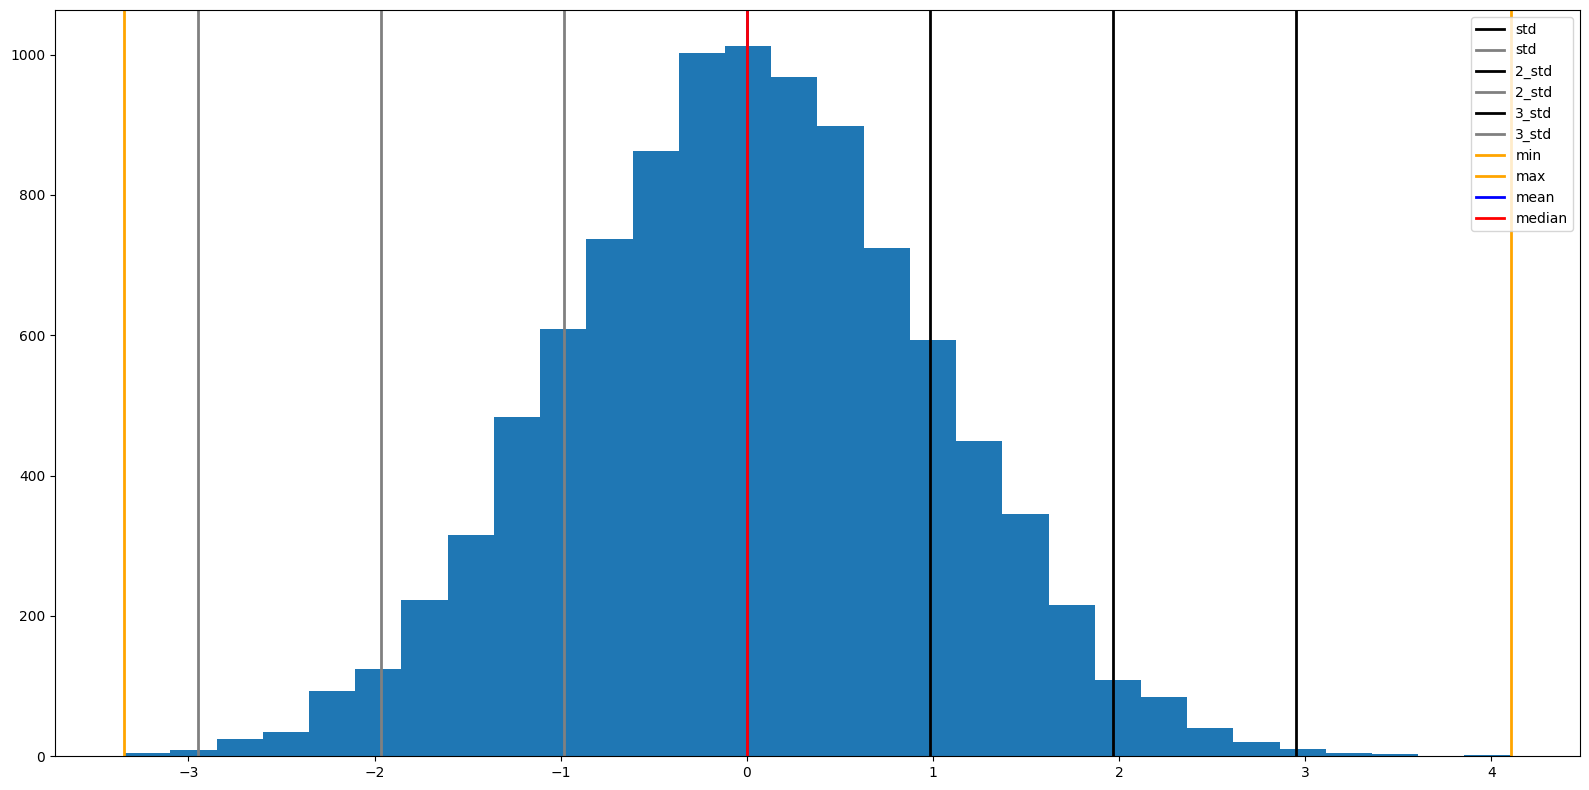

In [27]:
data = np.random.standard_normal(10000)
std = np.std(data)
mean = np.mean(data)
median = np.median(data)
print(f'std: {std}, mean: {mean}, median: {median}')

plt.figure(figsize=(16,8))
plt.hist(data, 30)
plt.axvline(mean+std, color='black', linestyle='-', linewidth=2, label='std')
plt.axvline(mean-std, color='gray', linestyle='-', linewidth=2, label='std')
plt.axvline(mean+2*std, color='black', linestyle='-', linewidth=2, label='2_std')
plt.axvline(mean-2*std, color='gray', linestyle='-', linewidth=2, label='2_std')
plt.axvline(mean+3*std, color='black', linestyle='-', linewidth=2, label='3_std')
plt.axvline(mean-3*std, color='gray', linestyle='-', linewidth=2, label='3_std')
plt.axvline(min(data), color='orange', linestyle='-', linewidth=2, label='min')
plt.axvline(max(data), color='orange', linestyle='-', linewidth=2, label='max')
plt.axvline(mean, color='blue', linestyle='-', linewidth=2, label='mean')
plt.axvline(median, color='red', linestyle='-', linewidth=2, label='median')

plt.legend()
plt.tight_layout()
plt.show()

In [10]:
train_data = train_data.drop(['Id', 'groupId', 'matchId', 'matchType'], axis=1)
#train_data_copy = data.sample(100000)
train_data_copy = train_data.copy()

threshold = train_data_copy.quantile(0.99)
train_data_copy = train_data_copy[train_data_copy <= threshold]

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


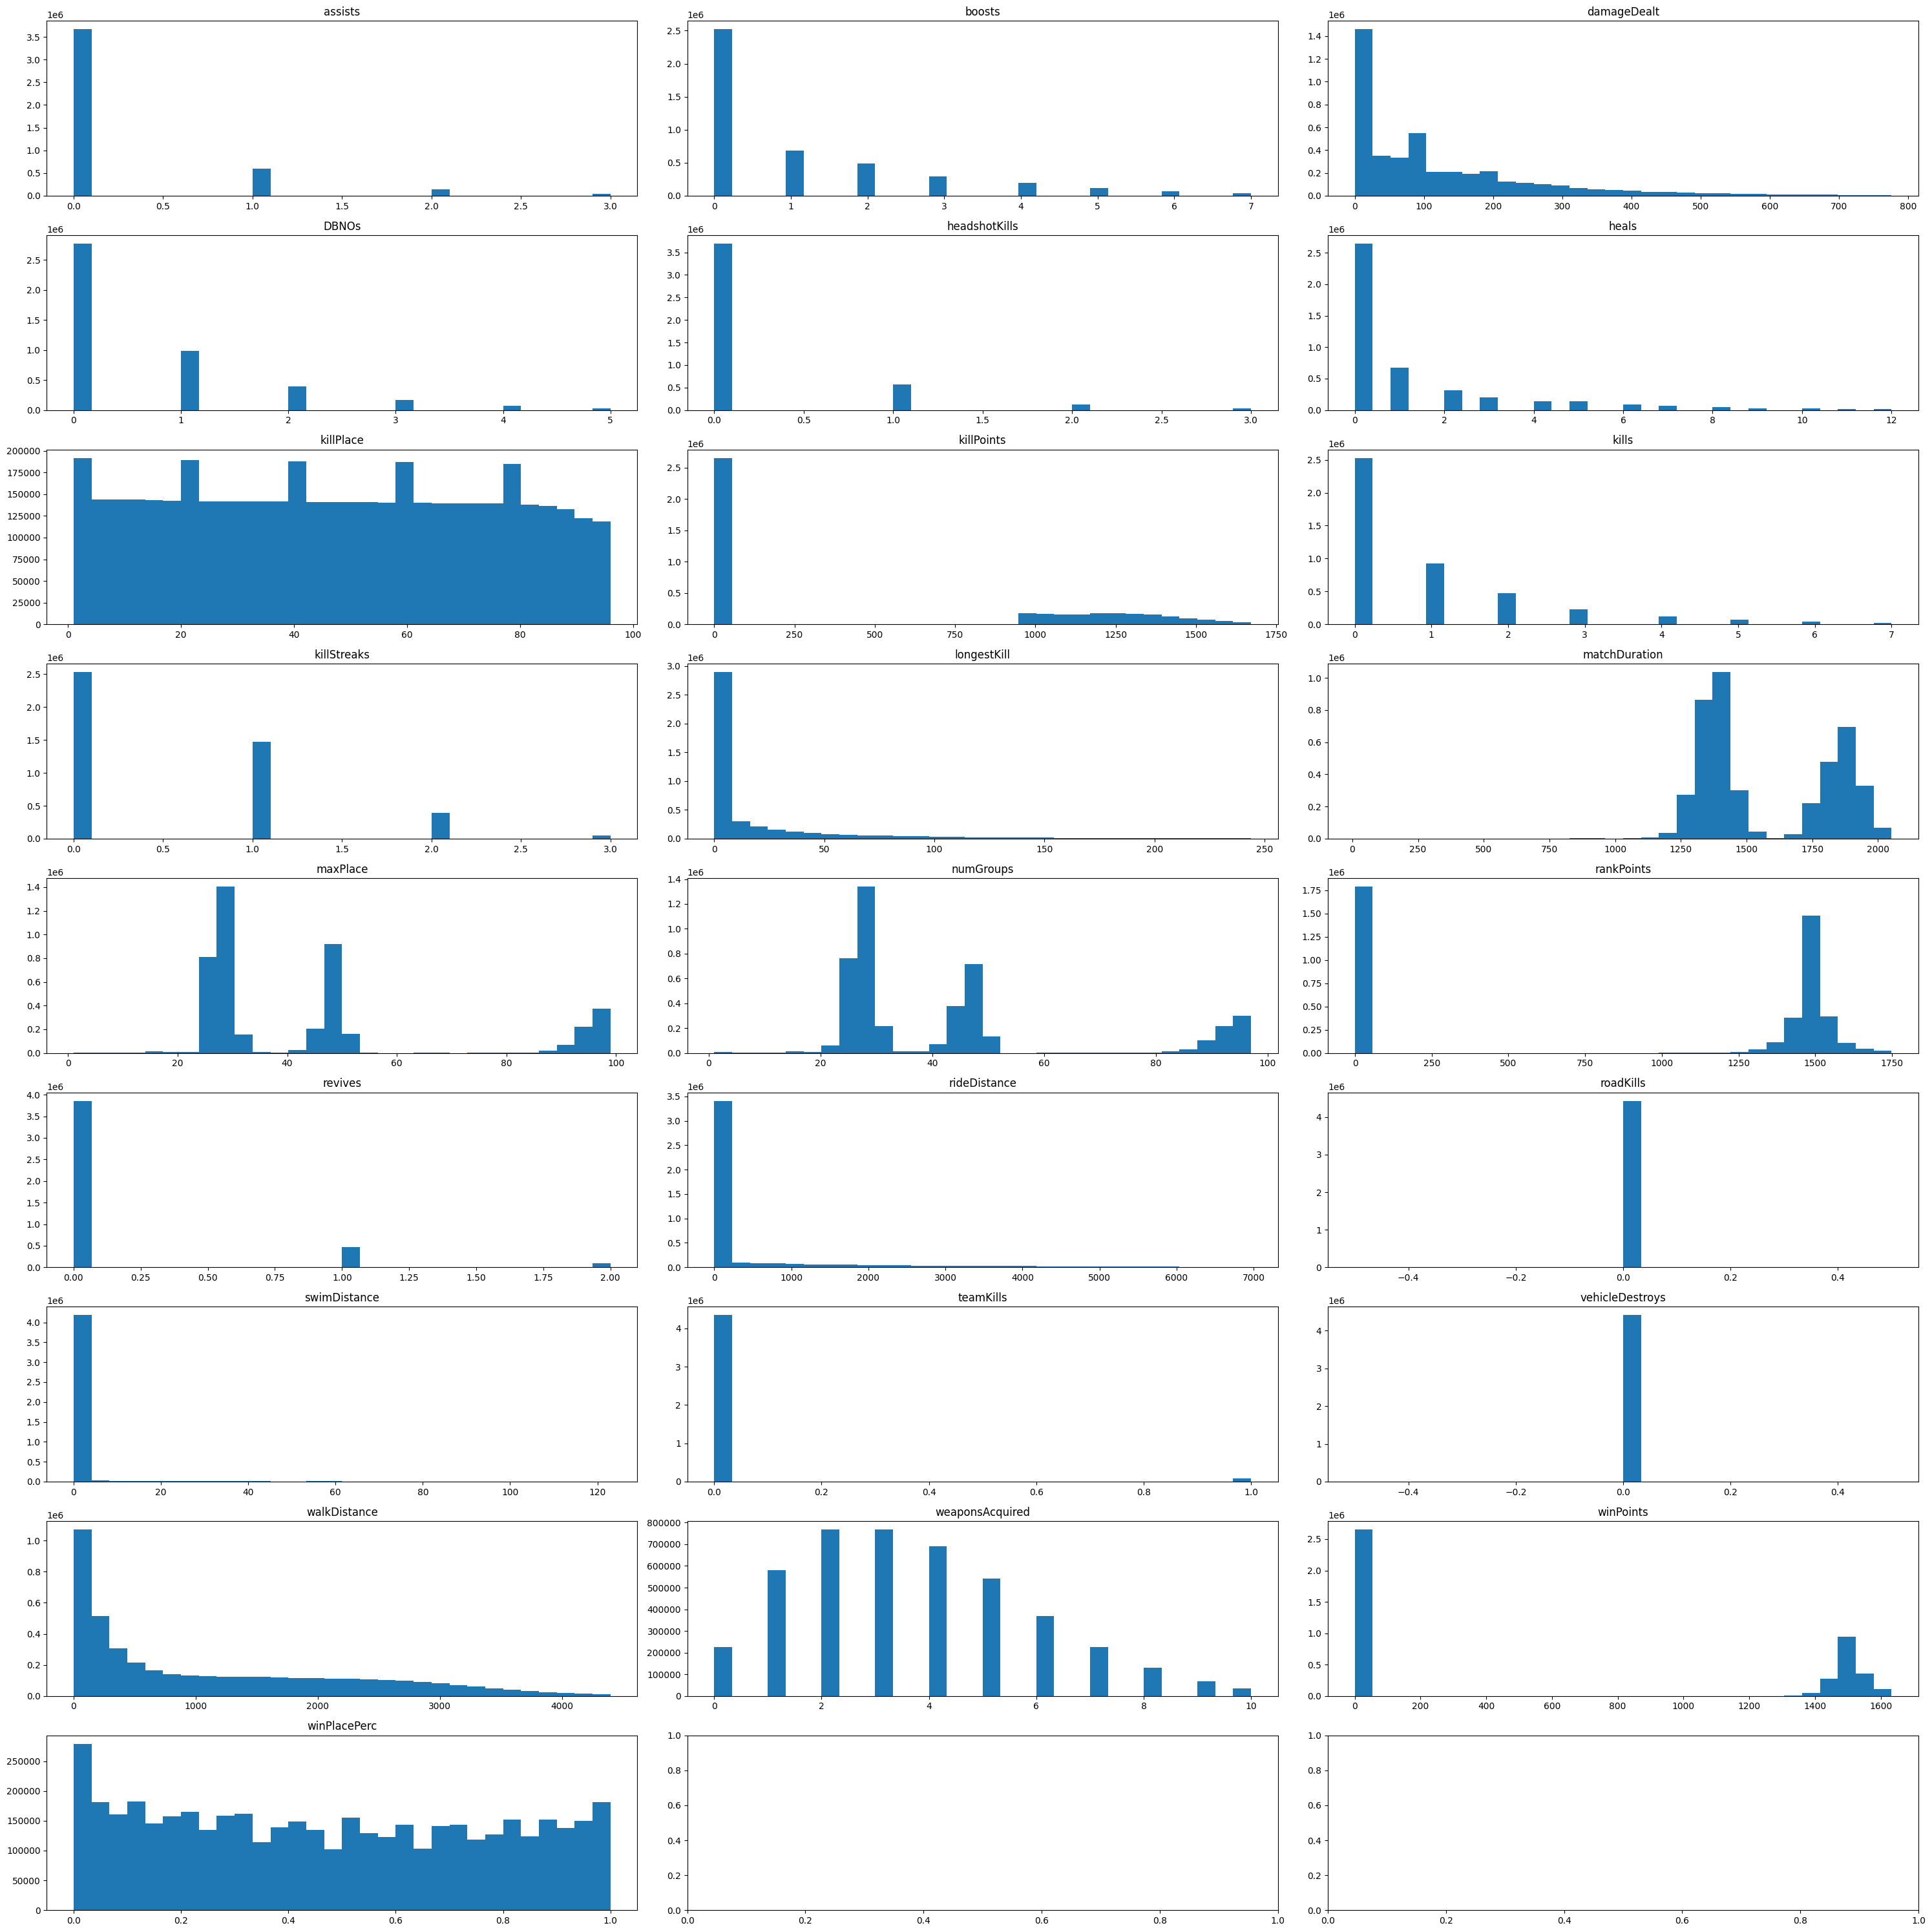

In [ ]:
fig, axs = plt.subplots(nrows=len(train_data_copy.columns)//3 + 1, ncols=3, figsize=(30,30))
axs = axs.flatten()

for idx, col in enumerate(train_data_copy.columns):
    axs[idx].hist(train_data_copy[col], bins=30)
    axs[idx].set_title(col)

plt.tight_layout()
plt.show()

In [ ]:
# check our data, except out target

# Set figure size
fig, axes = plt.subplots(nrows=3, ncols=len(X.columns)//3, figsize=(20, 10))
axes = axes.flatten()

# Loop through each column and plot distribution
for i, column in enumerate(X.columns):
    sns.histplot(X[column], kde=True, ax=axes[i], bins=20)
    axes[i].set_title(f"Distribution of {column}")

# Hide empty subplots if columns are fewer
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Check normal distribution

| **Method**                             | **Description**                                                                                | **Pros** 👍                                                                                                                                                    | **Cons** ⚠️                                                                              | **Typical Use Case**                    | **Practical Example**                                      |
| -------------------------------------- | ---------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------- | --------------------------------------- | ---------------------------------------------------------- |
| **🌟 Shapiro‑Wilk Test**               | Tests whether a sample comes from a normal distribution using order statistics.                | ✅ Highly powerful, especially for small-to-medium samples; widely available in `scipy`, R| ⚠️ Overly sensitive on large N; limited to continuous data; may flag trivial deviations  | Pre-testing before t-tests, regressions | Checking normality of residuals in regression (N ≈ 30–500) |
| **🔍 Anderson‑Darling Test**           | Gives more weight to tails; compares empirical vs theoretical distribution across whole range. | ✅ Sensitive to tail differences; stronger alternative to K‑S                                                                                                   | ⚠️ Requires distribution‑specific critical values; less intuitive; software-dependent    | Goodness-of-fit in full-range stats     | Testing residual normality including tail behavior         |
| **⚖️ Kolmogorov‑Smirnov (Lilliefors)** | Nonparametric; measures max deviation between empirical & theoretical CDF.                     | ✅ Simple; exact test when distribution known; works with small samples                                                                                         | ⚠️ Less sensitive in tails; wrong if parameters are estimated; often misused             | Quick sanity check; nonparametric tests | Comparing sample distribution to known normal CDF          |

In [ ]:
shapiro_test, p_value = stats.shapiro(train_data['damageDealt'])
kolmo_test, p_value_kolmo = stats.kstest(train_data['damageDealt'], 'norm')

# If our p_value is smaller than 0.05, we could reject null hypothesis and in this case reject that our data follow standard distribution
print(f"Shapiro - {shapiro_test}, {p_value} Kolmogorov - {kolmo_test}, {p_value_kolmo}")

Shapiro - 0.7325563066256384, 1.2327946025335427e-199 Kolmogorov - 0.7185073944791855, 0.0


### Confidence Interval
Range of values that’s likely to include the true population parameter (like the mean) based on your sample.  
It tells you how certain you are about your estimate.

**Purpose**: Estimate how close your sample mean is to the population mean.  

**Interpretation**: “We are 95% confident that the true mean falls between [lower bound, upper bound].”

**When to Use**:

* Evaluating feature distributions
* Estimating performance metrics (e.g., accuracy)
* Understanding prediction uncertainty
* A/B testing and statistical comparisons

In [ ]:
sample_data = train_data['damageDealt']
sample_mean = np.mean(sample_data)
sample_std_err = stats.sem(sample_data)
ci = stats.t.interval(0.95, len(sample_data)-1, loc=sample_mean, scale=sample_std_err)

print(f"Sample Mean: {sample_mean:.2f}")
print(f"95% Confidence Interval: ({ci[0]:.2f}, {ci[1]:.2f})")

Sample Mean: 130.72
95% Confidence Interval: (130.56, 130.88)


## Bivariate Analysis

### Heatmap

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/tmp/ipykernel_35/2807504447.py:8: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


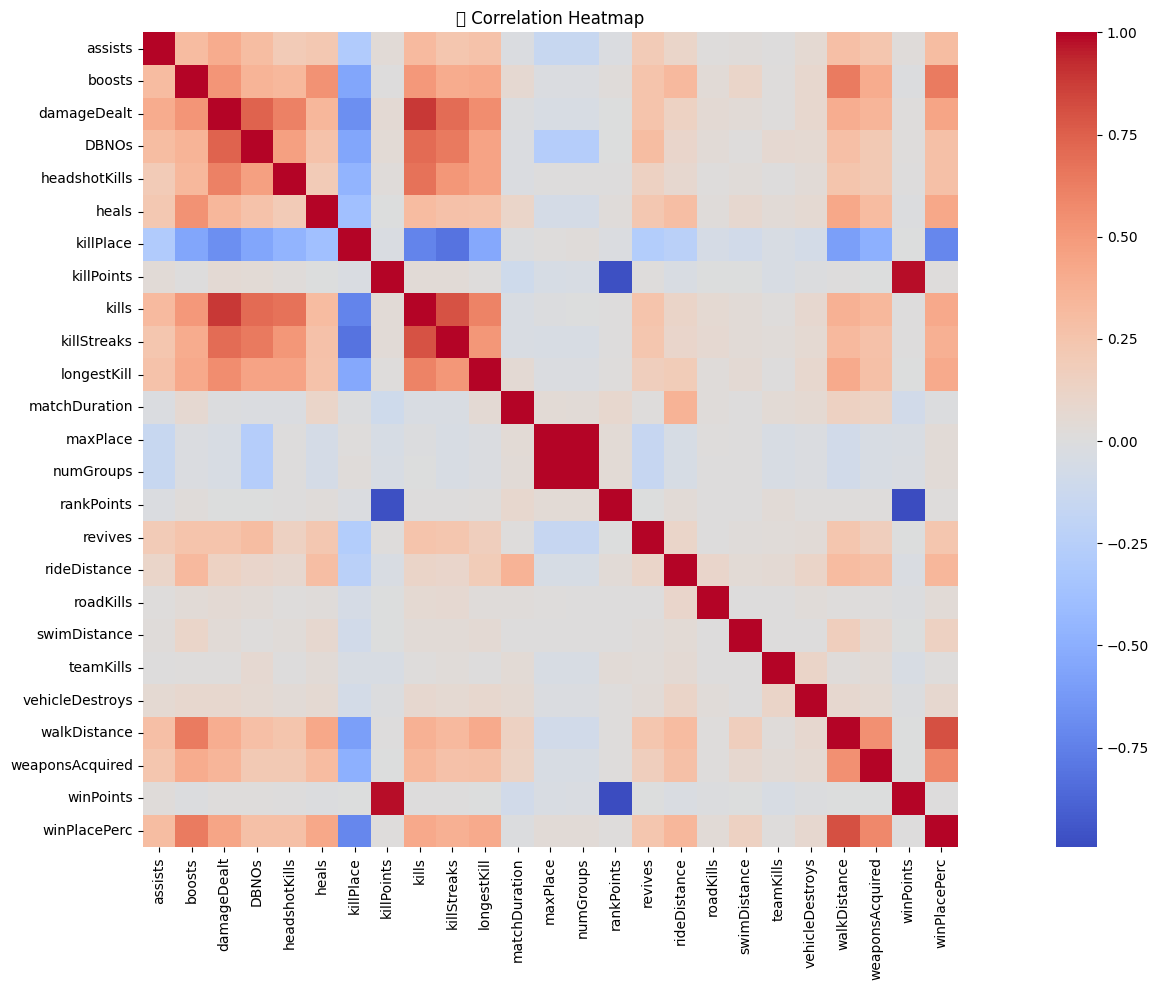

In [12]:
# Calculate the correlation matrix
corr_matrix = train_data.corr()

# Create the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, square=True)
plt.title("📊 Correlation Heatmap")
plt.tight_layout()
plt.show()

## Checking outliers/Missing Values

| **Method**                     | **Description**                                                            | **Pros**                                                      | **Cons**                                                               | **Practical Example**                              | **Use Cases**                                                |                     |
| ------------------------------ | -------------------------------------------------------------------------- | ------------------------------------------------------------- | ---------------------------------------------------------------------- | -------------------------------------------------- | ------------------------------------------------------------ | ------------------- |
| **Z-Score**                    | Measures how many standard deviations a data point is from the mean.       | Simple to implement; effective for normally distributed data. | Assumes normality; sensitive to extreme outliers.                      | Identifying unusually high test scores in a class. | Univariate outlier detection in normally distributed data.   |                     |
| **Interquartile Range (IQR)**  | Identifies outliers as points beyond 1.5×IQR from Q1 or Q3.                | Non-parametric; robust to non-normal distributions.           | Not suitable for multimodal distributions; limited to univariate data. | Spotting outliers in housing prices.               | Univariate outlier detection in skewed or non-normal data.   |                     |
| **Isolation Forest**           | Randomly partitions data to isolate anomalies quickly.                     | Efficient for large datasets; handles high-dimensional data.  | May struggle with clustered anomalies; randomness can affect results.  | Detecting anomalies in server log data.            | Anomaly detection in large-scale, high-dimensional datasets. |                     |

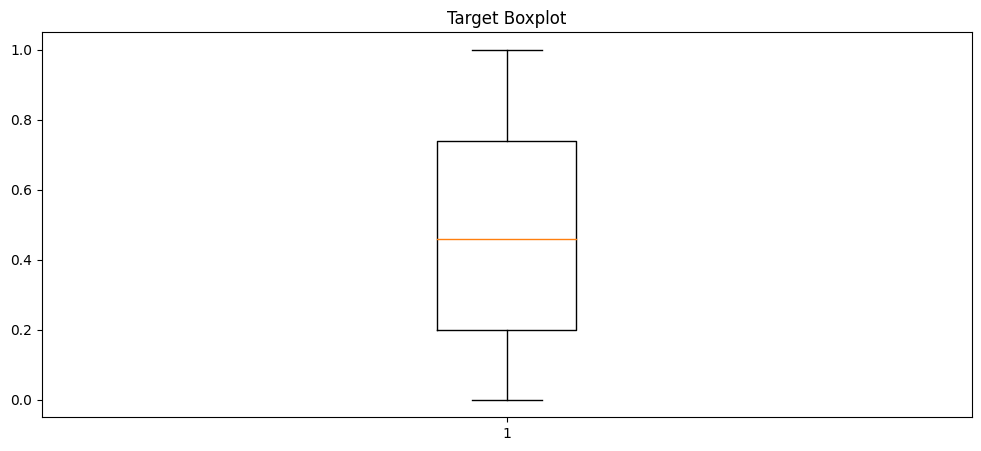

In [36]:
# Check box plot for outliners and distribution

plt.figure(figsize=(12, 5))
plt.boxplot(train_data['winPlacePerc'])
plt.title('Target Boxplot')
plt.show()

In [31]:
def check_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    IQR = Q3 - Q1

    lower_band = Q1 - 1.5 * IQR
    upper_band = Q3 + 1.5 * IQR

    print(f'IQR - {IQR}\nlower band - {lower_band}, upper band - {upper_band}')

    df = df[(df < lower_band) | (df > upper_band)]
    df_lower = df[df < lower_band]
    df_upper = df[df > upper_band]

    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df)
    plt.title(f"Outliers in {df.name}")
    plt.show()

    return df, df_lower, df_upper

In [ ]:
# Isolation Forest
outliers_forest = pd.DataFrame()

iso_forest = IsolationForest(contamination=0.1, random_state=42)
outliers_forest['Outlier_ISO'] = iso_forest.fit_predict(train_data[['damageDealt']])
outliers_forest['Outlier_ISO'] = outliers_forest['Outlier_ISO'].apply(lambda x: 'Outlier' if x == -1 else 'Normal')

IQR - 186.0
lower band - -279.0, upper band - 465.0


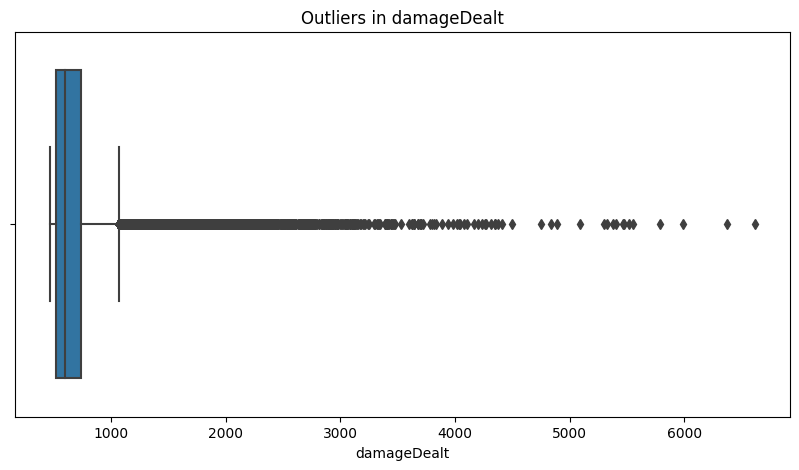

In [33]:
outliers, lower, upper = check_outliers(train_data['damageDealt'])

In [ ]:
# NaN values visualization

nan_counts = train_data.isna().sum()

# Plot bar chart
plt.figure(figsize=(20, 10))
nan_counts.plot(kind='bar', color='red', edgecolor='black')
plt.title("Missing Values Per Column")
plt.xlabel("Columns")
plt.ylabel("Count of NaNs")
plt.xticks(rotation=45)
plt.show()

## Data cleaning

### Missing Values

| **Method**                            | **Description**                                                  | **When to use**                                           | **Pros / Cons**                                          | **Code example (Python/pandas or sklearn)**        |
| ------------------------------------- | ---------------------------------------------------------------- | --------------------------------------------------------- | -------------------------------------------------------- | -------------------------------------------------- |
| **Drop rows/columns**                 | Remove rows/columns with missing values (`listwise deletion`)    | When missing < 5% or column is non‑critical               | ✅ Easy<br>❌ May lose data or bias sample if not MCAR     | `df.dropna(axis=0)`<br>`df.dropna(axis=1)`         |
| **Mean / Median / Mode imputation**   | Fill numeric missings with mean/median; categorical with mode    | When few missing values and MCAR                          | ✅ Simple<br>❌ Reduces variance, distorts correlations    | `df['col'].fillna(df['col'].mean(), inplace=True)` |
| **Forward / Backward fill (LOCF)**    | Use previous/next non‑missing value                              | Time‑series or ordered data                               | ✅ Keeps trend<br>❌ Biased if trend changes               | `df['col'].ffill(inplace=True)`                    |
| **Interpolation**                     | Linear, spline, etc. interpolation                               | Time/continuous data                                      | ✅ Smooth<br>❌ May oversmooth                             | `df['col'].interpolate(method='linear')`           |
| **KNN imputation**                    | Fill values from k‑nearest rows using distance on other features | When relationships between features matter; data MAR/MCAR | ✅ Captures multivariate patterns<br>❌ Slow on large data | `imputer = KNNImputer(n_neighbors=2)` <br> `X_filled = imputer.fit_transform(X)`|

**MCAR** – Missing Completely At Random  
The missingness is totally random and unrelated to any data—observed or missing (*A few survey responses are blank because the paper forms smudged during printing*)  
✅ Safe to drop rows or use simple imputation (mean, median, mode)

**MAR** – Missing At Random  
Missingness depends on observed data, not on the value that’s missing (*People under 25 are less likely to report their income in the survey*)  
✅ Use more advanced imputations (e.g. KNN, multiple imputation, regression imputation).

**MNAR** – Missing Not At Random  
The missingness is related to unobserved or missing data itself (*People with higher incomes don’t report income*)  
🛠 Consider modeling the missingness (e.g. using indicator variables, or building a predictive model for missing values).  

In [4]:
# drop unimportant values
train_data.drop(['Id', 'groupId', 'matchId', 'matchType'], axis=1, inplace=True)

# remove nan values
train_data.dropna(inplace=True)

## Data transformation and encoding

| Technique | Example Input | Example Output | When to Use | Code |
|-----------|---------------|----------------|-------------|------|
| **🏷️ Encoding** | `['dog', 'cat', 'bird']` | `[0, 1, 2]` or `[[1,0,0], [0,1,0], [0,0,1]]` | Non-numerical features | `LabelEncoder()` |
| **📏 Scaling** | `[25, 35, 45]` (age) | `[-1.22, 0, 1.22]` | Different feature scales | `StandardScaler()` |
| **🔢 Binning** | `[22, 28, 35, 42, 58]` | `['Young', 'Young', 'Middle', 'Middle', 'Senior']` | Reduce noise, handle outliers | `pd.cut()` |
| **📈 Transformation** | `[1, 10, 100, 1000]` | `[0, 1, 2, 3]` (log) | Skewed data, non-linear | `np.log1p()` |
| **🧮 Creation** | Height: `170cm`, Weight: `70kg` | BMI: `24.2` | Domain knowledge available | Custom functions |
| **✂️ Selection** | 20 features | 5 most important | High dimensionality | `SelectKBest()` |
| **🕒 Time Features** | `'2024-03-15 14:30:00'` | Hour: `14`, DayOfWeek: `4`, Month: `3` | Extract temporal patterns | `dt.hour, dt.dayofweek` |
| **📝 Text Features** | `'I love this product'` | `[0, 2, 0, 1, 1]` (word counts) | Process text data| `CountVectorizer()` |

### Categorical Encoding Table

| Method | Input Example | Output Example | When to Use | Pros | Cons | Code Example |
|--------|---------------|----------------|-------------|------|------|--------------|
| **One-Hot** 🎨 | `['red', 'blue', 'green']` | `red:[1,0,0] blue:[0,1,0] green:[0,0,1]` | Low cardinality (<10-15 categories) | No ordinal assumption, works with all algorithms | High dimensionality, sparse data | `pd.get_dummies(df['color'])` |
| **Label** 🏷️ | `['small', 'medium', 'large']` | `[0, 1, 2]` | Tree-based models, high cardinality | Memory efficient, fast | Implies false ordering | `LabelEncoder().fit_transform(df['size'])` |
| **Target** 🎯 | City:`['NYC', 'LA']` Target:`[0.8, 0.6]` | `NYC:0.8, LA:0.6` | High cardinality (>20 categories) | Captures target relationship | Overfitting risk, needs CV | `df.groupby('city')['target'].mean()` |
| **Binary** 💻 | `['A', 'B', 'C', 'D']` | `A:[0,0] B:[0,1] C:[1,0] D:[1,1]` | Very high cardinality | Compact, logarithmic growth | Less interpretable | Custom binary conversion |
| **Ordinal** 📊 | `['Poor', 'Fair', 'Good', 'Excellent']` | `[1, 2, 3, 4]` | Natural ordering exists | Preserves meaningful order | Requires domain knowledge | `{'Poor':1, 'Fair':2, 'Good':3, 'Excellent':4}` |
| **Frequency** 📊 | `['A', 'B', 'A', 'C']` | `A:2, B:1, C:1` | Frequency matters | Simple, captures popularity | Loses categorical meaning | `df['cat'].value_counts()` |

### Scaling Methods Table

| Method | Input Example | Output Example | Formula | When to Use | Pros | Cons | Code |
|--------|---------------|----------------|---------|-------------|------|------|------|
| **StandardScaler** 📊 | `[10, 20, 30]` | `[-1.22, 0, 1.22]` | `(x-μ)/σ` | Normal distribution, SVM, Neural Networks | Zero mean, unit variance | Sensitive to outliers | `StandardScaler()` |
| **MinMaxScaler** 📏 | `[10, 20, 30]` | `[0, 0.5, 1]` | `(x-min)/(max-min)` | Bounded range needed, preserve zero, Convnet | Bounded [0,1] range | Very sensitive to outliers | `MinMaxScaler()` |
| **RobustScaler** 💪 | `[10, 20, 30, 100]` | `[-0.5, 0, 0.5, 4]` | `(x-median)/IQR` | Outliers present | Robust to outliers | Doesn't guarantee bounds | `RobustScaler()` |
| **Normalizer** 🔄 | `[3, 4]` | `[0.6, 0.8]` | `x/\|\|x\|\|` | Text data, cosin similarity | Unit norm per sample | Changes relative magnitudes | `Normalizer()` |
| **MaxAbsScaler** 🔝 | `[-10, 0, 30]` | `[-0.33, 0, 1]` | `x/max(\|x\|)` | Sparse data, preserve zeros | Preserves sparsity | Sensitive to outliers | `MaxAbsScaler()` |

In [ ]:
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

docs = ["This is a sentence", "Another sentence", "This one is longer and has more words"]

# Vectorize
vectorizer = TfidfVectorizer(norm=None)
X = vectorizer.fit_transform(docs)

# Normalize
normalizer = Normalizer()
X_normalized = normalizer.transform(X)

display(X.toarray())
display(X_normalized.toarray())

(X_normalized @ X.T).toarray() # cosin similarities on normalized data

### Binning Strategies

| Binning Type | Input Example | Output Example | When to Use | Pros | Cons | Code Example |
|--------------|---------------|----------------|-------------|------|------|--------------|
| **Equal Width** 📊 | Ages:`[22, 28, 35, 42, 58, 65]` | `['18-30', '30-42', '42-54', '54-66']` | Uniform distribution | Equal intervals, interpretable | Uneven group sizes | `pd.cut(df['age'], bins=4)` |
| **Equal Frequency** ⚖️ | Income:`[25K, 35K, 45K, 65K, 85K, 120K]` | `['Low', 'Medium', 'High', 'VeryHigh']` (equal counts) | Skewed distributions | Balanced group sizes | Uneven intervals | `pd.qcut(df['income'], q=4)` |
| **Custom/Domain** 🎯 | Credit:`[580, 650, 720, 780]` | `['Poor', 'Fair', 'Good', 'Excellent']` | Domain knowledge available | Meaningful business groups | Requires expertise | `pd.cut(bins=[0,600,700,800,850])` |
| **K-means** 🎲 | Data:`[1,2,3,10,11,12,20,21,22]` | 3 clusters based on similarity | Natural groupings exist | Data-driven boundaries | Complex, needs tuning | `KMeans(n_clusters=3)` |

### Transformation Techniques Table

| Transform | Input Example | Output Example | When Original Data Is | Pros | Cons | Use Cases |
|-----------|---------------|----------------|-----------------------|------|------|-----------|
| **Log** 📈 | `[1, 10, 100, 1000]` | `[0, 2.3, 4.6, 6.9]` | **Positive**, right-skewed, exponential growth | Reduces skewness, stabilizes variance | Can't handle zeros/negatives | Income, population, web traffic |
| **Square Root** √ | `[1, 4, 9, 16, 25]` | `[1, 2, 3, 4, 5]` | **Mild positive**, count data, moderate skewness | Handles zeros, less aggressive than log | Still can't handle negatives | Count data, rates |
| **Box-Cox** 📦 | `[1, 2, 3, 4, 5]` λ=0.5 | `[0, 1.83, 2.45, 3, 3.47]` | **Positive**, need optimal normality | Finds optimal transformation | Needs positive data, complex | Statistical modeling |
| **Yeo-Johnson** 🔄 | `[-2, -1, 0, 1, 2]` | `[-1.41, -0.69, 0, 0.69, 1.41]` | Mixed positive/negative/zero, **Most Flexible** | Handles all values | Less interpretable | General purpose |
| **Reciprocal** 🔃 | `[1, 2, 4, 8]` | `[1, 0.5, 0.25, 0.125]` | **Strong positive**, eavy right tail, inverse relationship | Flips skewness | Can't handle zeros | Time-to-event, rates |

✅ Require or Benefit from **Normality**:
* Linear Regression (normal residuals for inference) 
* Logistic Regression (parametric estimate, convergence)
* LDA / QDA (Gaussian features per class) 
* Gaussian Naive Bayes (feature-wise Gaussian assumption) 
* Gaussian Processes / Probit (Gaussian noise/model)

❌ **No Normality** Required
* Decision Trees / Random Forest (tree splits unaffected by distribution) 
* XGBoost / Gradient Boosted Trees (likewise tree-based) 
* K‑Nearest Neighbors (KNN) (distance-based, needs scaling not normality) 
* Support Vector Machines (SVM) (margin-based, scale but no normality) 
* Neural Networks (universal approximators; scaling helps)
* PCA / clustering (eigen/decomposition & distance-based)

In [ ]:
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

col_name = 'walkDistance'
train_data_copy_walk = train_data_copy[col_name]
train_data_copy_walk = train_data_copy_walk[train_data_copy_walk != 0]
train_data_copy_walk.dropna(inplace=True)


pt = PowerTransformer(method='yeo-johnson')
johnson_data = pt.fit_transform(train_data_copy_walk[0:1000].to_numpy().reshape(-1, 1))

normal_data = train_data_copy_walk
log_data = np.log(train_data_copy_walk)
sqrt_data = np.sqrt(train_data_copy_walk)
reciprocal = 1/train_data_copy_walk
boxcox_data, _ = boxcox(train_data_copy_walk[0:1000])

data_viz = [normal_data, log_data, sqrt_data, reciprocal, boxcox_data, johnson_data]

display(normal_data.head())
display(log_data.head()) # Log
display(sqrt_data.head()) # Square root
display(reciprocal.head()) # Reciprocal
display(pd.DataFrame(boxcox_data).head()) # Box-Cox
display(pd.DataFrame(transformed).head()) # Yeo-Johnson

0     244.80
1    1434.00
2     161.80
3     202.70
4      49.75
Name: walkDistance, dtype: float64

0    5.500442
1    7.268223
2    5.086361
3    5.311727
4    3.907010
Name: walkDistance, dtype: float64

0    15.646086
1    37.868192
2    12.720063
3    14.237275
4     7.053368
Name: walkDistance, dtype: float64

0    0.004085
1    0.000697
2    0.006180
3    0.004933
4    0.020101
Name: walkDistance, dtype: float64

0
0  11.453653
1  19.726762
2   9.973634
3  10.760838
4   6.483291

0
0 -0.629284
1  0.621875
2 -0.853625
3 -0.734297
4 -1.381806

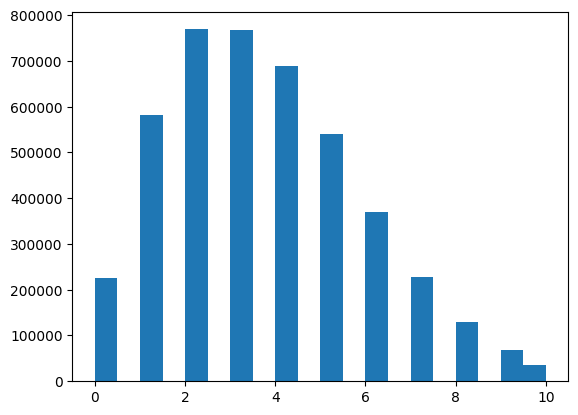

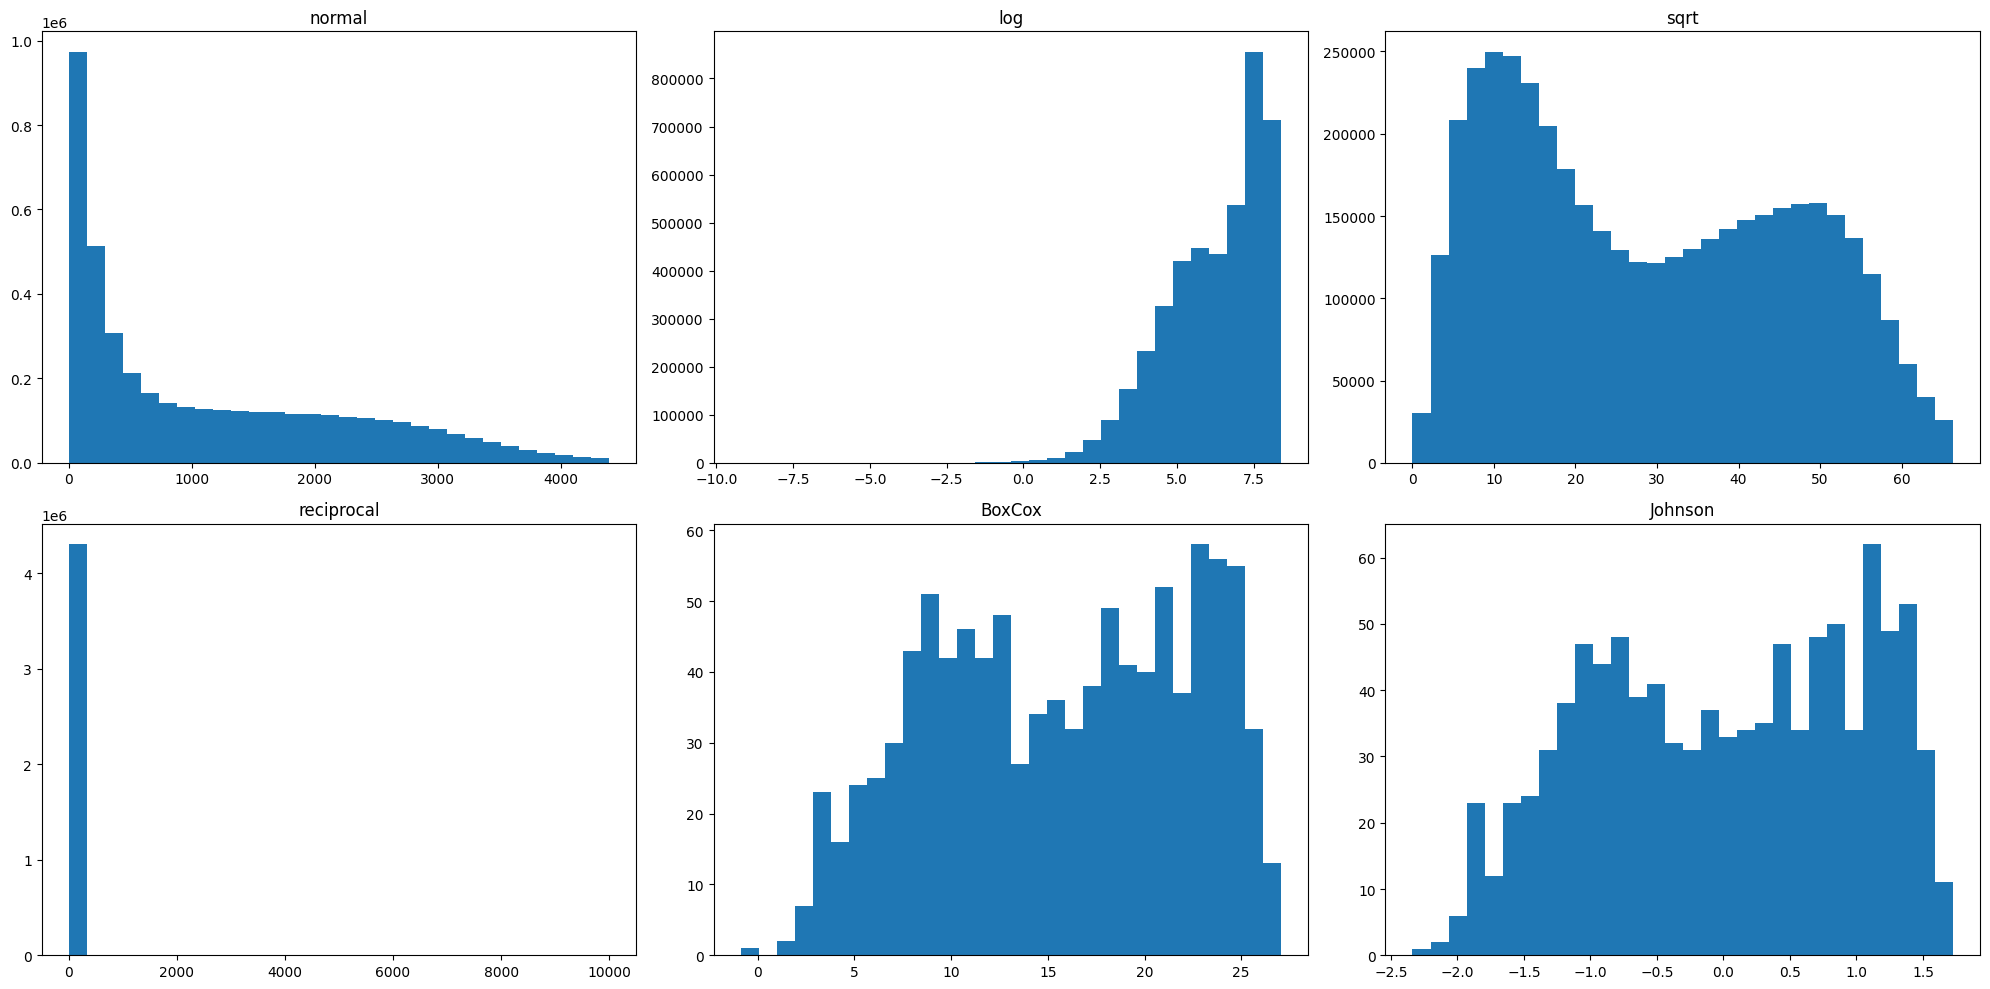

In [ ]:
plt.hist(train_data_copy['weaponsAcquired'], bins=20)
plt.show()

weapon_transform = np.sqrt(train_data_copy['weaponsAcquired'])

axs_names = ['normal', 'log', 'sqrt', 'reciprocal', 'BoxCox', 'Johnson']
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
axs = axs.flatten()
for idx, data in enumerate(data_viz):
    axs[idx].hist(data, bins=30)
    axs[idx].set_title(axs_names[idx])

plt.tight_layout()
plt.show()

### Time-Based Features Table

| Feature Type | Input Example | Output Examples | When to Use | Pros | Cons | Code Example |
|--------------|---------------|-----------------|-------------|------|------|--------------|
| **Date Parts** 📅 | `'2024-03-15 14:30:00'` | Year:`2024`, Month:`3`, Day:`15`, Hour:`14` | Always with datetime | Simple, interpretable | Linear treatment of cyclical | `df['date'].dt.year` |
| **Cyclical** 🔄 | Hour:`14` | `sin:0.26, cos:-0.97` | Cyclical patterns matter | Captures periodicity properly | Doubles feature count | `np.sin(2*π*hour/24)` |
| **Boolean** ✅ | `'2024-03-15'` (Friday) | `is_weekend:0, is_holiday:0` | Binary time patterns | Simple, clear interpretation | Many sparse features | `df['date'].dt.dayofweek >= 5` |
| **Lag Features** ⏪ | Sales:`[100, 120, 110, 130]` | `lag_1:[NaN, 100, 120, 110]` | Time series forecasting | Captures temporal dependencies | Creates missing values | `df['sales'].shift(1)` |
| **Rolling** 📊 | Sales:`[100, 120, 110, 130, 140]` | `rolling_mean_3:[NaN, NaN, 110, 120, 127]` | Trend analysis needed | Smooths noise, shows trends | Reduces data, needs window choice | `df['sales'].rolling(3).mean()` |

### Text Feature Engineering Table

| Technique | Input Example | Output Example | When to Use | Pros | Cons | Code Example |
|-----------|---------------|----------------|-------------|------|------|--------------|
| **Bag of Words** 👜 | `"I love cats"` | `[1, 1, 1, 0, 0]` (I:1, love:1, cats:1, dogs:0, hate:0) | Simple text classification | Easy to implement | Ignores word order, sparse | `CountVectorizer()` |
| **TF-IDF** 📊 | `"cats are great"` | `[0.57, 0.57, 0.57]` (weighted by rarity) | Text importance matters | Reduces common word impact | Still ignores context | `TfidfVectorizer()` |
| **N-grams** 🔗 | `"I love cats"` | Bigrams: `['I love', 'love cats']` | Word order important | Captures some context | Exponential feature growth | `ngram_range=(1,2)` |
| **Length Features** 📏 | `"Hello world!"` | `char_count:12, word_count:2, avg_word_len:5.5` | Text structure matters | Simple, fast | Limited information | `len(text), len(text.split())` |
| **Sentiment** 😊 | `"I love this product"` | `sentiment_score:0.8, is_positive:1` | Emotion detection needed | Captures meaning | Requires external tools | `TextBlob(text).sentiment` |
| **Word Embeddings** 🎯 | `"This movie was great"`| Contextual vector for each word | When word meaning depends on context  | Context-aware, state-of-the-art | Heavy, slower, complex fine-tuning | `transformers.BertModel` |

### ❌ What to Avoid

| ❌ Mistake | Example | Why It's Wrong | ✅ Correct Approach | Impact |
|------------|---------|----------------|-------------------|---------|
| **Target Leakage** | Using `purchase_date` to predict `will_purchase` | Future info in features | Only use info available before prediction | Inflated performance |
| **Data Leakage** | Scaling before train/test split | Test info leaks into training | Split first, then transform | Overly optimistic results |
| **High Cardinality One-Hot** | One-hot encoding ZIP codes (1000+ values) | Creates 1000+ sparse features | Use target encoding or embedding | Curse of dimensionality |
| **Ignoring Domain** | Generic features for medical data | Misses important relationships | Create medically meaningful features | Poor real-world performance |
| **Over-Engineering** | 500 features for 100 samples | More features than samples | Feature selection or regularization | Severe overfitting |

In [ ]:
# encode string values to ints
train_data['matchType'], mapping = pd.factorize(train_data['matchType'])
match_type = {value: index for value, index in enumerate(mapping)}

## Feature Engineering

### Feature Creation

| Feature Type | Input Features | Formula/Logic | Output Feature | Domain | Pros | Cons |
|--------------|----------------|---------------|----------------|---------|------|------|
| **Ratios** 📊 | Income:`50000`, Experience:`5yr` | `income/experience` | `income_per_year:10000` | HR, Finance | Captures efficiency | Division by zero risk |
| **Differences** ➖ | Current:`25`, Previous:`20` | `current - previous` | `change:5, pct_change:25%` | Time series | Shows trends | Sensitive to outliers |
| **Polynomials** 📈 | Age:`30` | `age², age³` | `age_squared:900` | Non-linear relationships | Captures curves | Overfitting risk |
| **Interactions** 🤝 | Gender:`Male`, Age:`30` | `gender × age` | `male_age:30` (if male=1, else 0) | Marketing, Medicine | Captures combined effects | Exponential feature growth |
| **Aggregations** 📊 | User purchases:`[10, 20, 15]` | `mean, sum, std, count` | `avg_purchase:15, total_spent:45` | Customer analytics | Rich summary stats | Loss of individual info |
| **Distance** 📏 | Lat:`40.7`, Lon:`-74.0` | `haversine distance` | `distance_to_center:5.2km` | Location-based | Captures spatial relationships | Needs reference point |

### Feature Selection

| Method | Example | Selection Criteria | Pros | Cons | When to Use | Code |
|--------|---------|-------------------|------|------|-------------|------|
| **Correlation** 🔗 | Features:`[age, income, education, experience]` | Remove if `corr > 0.9` with others | Simple, fast | Only linear relationships | Multicollinearity issues | `corr_matrix > 0.9` |
| **Variance** 📊 | `[constant_col:all_5, varying_col:1-100]` | Keep if `variance > threshold` | Removes useless features | May remove useful low-variance | Many constant features | `VarianceThreshold(0.01)` |
| **Univariate** 📈 | 10 features, target | Top k by statistical test | Fast, model-agnostic | Ignores feature interactions | High-dimensional data | `SelectKBest(f_classif, k=5)` |
| **Tree Importance** 🌳 | All features | Feature importance scores | Works with non-linear | Model-specific | Tree-based final model | `RandomForest.feature_importances_` |

#### Correlation

| **Method**          | **What It Does**                                                          | **When to Use**                                                                                       | **Pros** 👍                                                                    | **Cons** ⚠️                                                                       | **Example**                                                                    |
| ------------------- | ------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------ | --------------------------------------------------------------------------------- | ------------------------------------------------------------------------------ |
| **Pearson**         | Measures *linear* relationship strength between two continuous variables. | Both variables are interval/ratio, approximately **normally distributed**, relationship is linear.    | Simple to compute; interprets magnitude & direction of *linear* correlation.   | **Sensitive to outliers**, assumes normality and homoscedasticity.                | Checking correlation between height and weight of adults                       |
| **Spearman** (ρ)    | Measures *monotonic* relationship via ranked data.                        | Data is ordinal or **not normally distributed**, or relationship is non-linear but monotonic.         | Robust to outliers, non-parametric, handles ordinal and rank data.             | Rank-based: less sensitive to magnitude changes, may lose information.            | Ranking of students' performance across two tests                              |
| **Kendall** (τ)     | Measures ordinal association by comparing concordant/discordant pairs.    | Ordinal data, small samples, many ties, or when requiring a conservative estimate.                    | More **conservative**, interpretable via *pair probability*, robust with ties. | Slightly slower to compute, may be less intuitive.                                | Comparing reviewers’ ranked preferences for a set of items                     |
| **Chi-Square** (χ²) | Tests *independence* between two **categorical** variables.               | When you want to test if there's an association between two nominal or ordinal categorical variables. | Non-parametric, easy to implement, works with frequency data.                  | Requires sufficient expected frequencies; doesn't show *strength* or *direction*. | Testing if gender and voting preference are independent in a sample population |

<br>
<br>

|**r(rho) Value**  | **Strength**      | **Description**                       | **When to Use**                               | **Quick Example**                             |
| ----------------- | ----------------- | ------------------------------------- | --------------------------------------------- | --------------------------------------------- |
| **±0.80 to 1.00** | 🌟 Very Strong    | Almost perfect monotonic relationship | When predictors are highly aligned            | Age and years of work experience (ρ = 0.85)   |
| **±0.60 to 0.79** | ✅ Strong          | Clear and meaningful association      | When variables show a consistent trend        | Temperature vs. ice cream sales (r ≈ 0.70)    |
| **±0.40 to 0.59** | ✔️ Moderate       | Noticeable but moderate dependency    | When moderate predictive power is expected    | Reading hours vs. grades (r ≈ 0.50)           |
| **±0.20 to 0.39** | ⚠️ Weak           | Slight monotonic relationship         | When relationship exists but with variability | Social media time vs. stress level (ρ ≈ 0.30) |
| **0.00 to 0.19**  | 🚫 Very Weak/None | Essentially no monotonic correlation  | When variables are mostly independent         | Shoe size vs. favorite movie rating (r ≈ 0)   |
                                                                                                               |

In [ ]:
rho, p_value = stats.spearmanr(train_data['damageDealt'], train_data['winPlacePerc'])
print(f'Correlation between feature and y: {rho} and p_value - {p_value}')

# Visualizing
# plt.scatter(train_data['damageDealt'], train_data['winPlacePerc'], label='All data', alpha=0.5)
# plt.scatter(train_data['damageDealt'], train_data['winPlacePerc'], color='red', label='Outliers', edgecolors='black')
# plt.xlabel('Feature')
# plt.ylabel('Y')
# plt.legend()
# plt.title('Correlation between outliers and y')
# plt.show()

Correlation between feature and y: 0.44859106232490664 and p_value - 0.0


In [ ]:
# Chi-Square
# Sample categorical data
data = {
    'Pet': ['Dog', 'Cat', 'Dog', 'Dog', 'Cat', 'Cat', 'Dog', 'Cat', 'Dog', 'Cat'],
    'Area': ['Urban', 'Urban', 'Rural', 'Urban', 'Rural', 'Rural', 'Urban', 'Urban', 'Rural', 'Rural']
}

chi_data = pd.DataFrame(data)

# Create a contingency table
contingency_table = pd.crosstab(chi_data['Pet'], chi_data['Area'])
print("Contingency Table:\n", contingency_table)

# Run the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-square statistic:", chi2) # how big is the difference between observed and expected values
print("Degrees of freedom:", dof) # How many pieces of informations we need to get, to be able to fill rest of the table (we assume we know sums of every rows and columns)
print("P-value:", p) # are our results statisticaly significant
print("Expected frequencies:\n", expected)

# Interpret result
alpha = 0.05
if p < alpha:
    print("\n✅ There IS a statistically significant relationship between Pet and Area.")
else:
    print("\n❌ There is NO statistically significant relationship between Pet and Area.")


Contingency Table:
 Area  Rural  Urban
Pet               
Cat       3      2
Dog       2      3

Chi-square statistic: 0.0
Degrees of freedom: 1
P-value: 1.0
Expected frequencies:
 [[2.5 2.5]
 [2.5 2.5]]

❌ There is NO statistically significant relationship between Pet and Area.


#### Variance
Tells you how spread out your data is. It measures how far each number in a dataset is from the average (mean).  

**Purpose**: Remove features with low variance, assuming they carry little information.

**Key Idea**: If a feature doesn’t change much across data points (e.g., 95% of values are “1”), it’s unlikely to help a model learn patterns.

In [ ]:
from sklearn.feature_selection import VarianceThreshold

train_data_copy = train_data.copy()
train_data_copy.drop(['Id', 'groupId', 'matchId', 'matchType'], inplace=True, axis=1)
selector = VarianceThreshold(threshold=0.01).set_output(transform='pandas')
X_reduced = selector.fit_transform(train_data_copy)

print(f'removed columns: {train_data_copy.columns[~selector.get_support()]}')

removed columns: Index(['roadKills', 'vehicleDestroys'], dtype='object')


### Dimensionality reduction

Transforms high-dimensional data into a lower-dimensional space while preserving structure and information. There are two main categories:

* Feature Extraction: Create new features (linear or non-linear combinations).

* Feature Selection: Select a subset of original features.

| Method    | Category   | Typical Use                               | Complexity   | Main Hyperparameters         | What it does (short)                                               | Code Snippet                                                                                                                      |
| --------- | ---------- | ----------------------------------------- | ------------ | ---------------------------- | ------------------------------------------------------------------ | --------------------------------------------------------------------------------------------------------------------------------- |
| **PCA**   | Linear     | Exploratory analysis; feature compression | O(n d² + d³) | `n_components`               | Projects data onto orthogonal axes of highest variance             |`from sklearn.decomposition import PCA` <br> `pca = PCA(n_components=2)` <br> `X_pca = pca.fit_transform(X)`                |
| **Kernel PCA** | Non-linear | Capturing non-linear structure            | O(n³)        | `n_components`, `kernel`, `gamma` | Applies PCA in a high-dimensional feature space via a kernel trick |`from sklearn.decomposition import KernelPCA` <br> `kpca = KernelPCA(n_components=2, kernel='rbf', gamma=10)` <br> `X_kpca = kpca.fit_transform(X)` |
| **t-SNE** | Non-linear | Visualizing clusters in 2D/3D             | O(n²)        | `n_components`, `perplexity` | Places similar points together by matching high-/low-D distances   | `from sklearn.manifold import TSNE` <br> `tsne = TSNE(n_components=2, perplexity=30)` <br> `X_tsne = tsne.fit_transform(X)` |
| **UMAP**  | Non-linear | Fast embedding for large datasets         | O(n log n)   | `n_neighbors`, `min_dist`    | Builds neighbor graph and finds a low-D layout preserving topology | `import umap` <br> `umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1)` <br> `X_umap = umap_model.fit_transform(X)`


Explained variance ratio by each component:
[0.25946781 0.12508585]


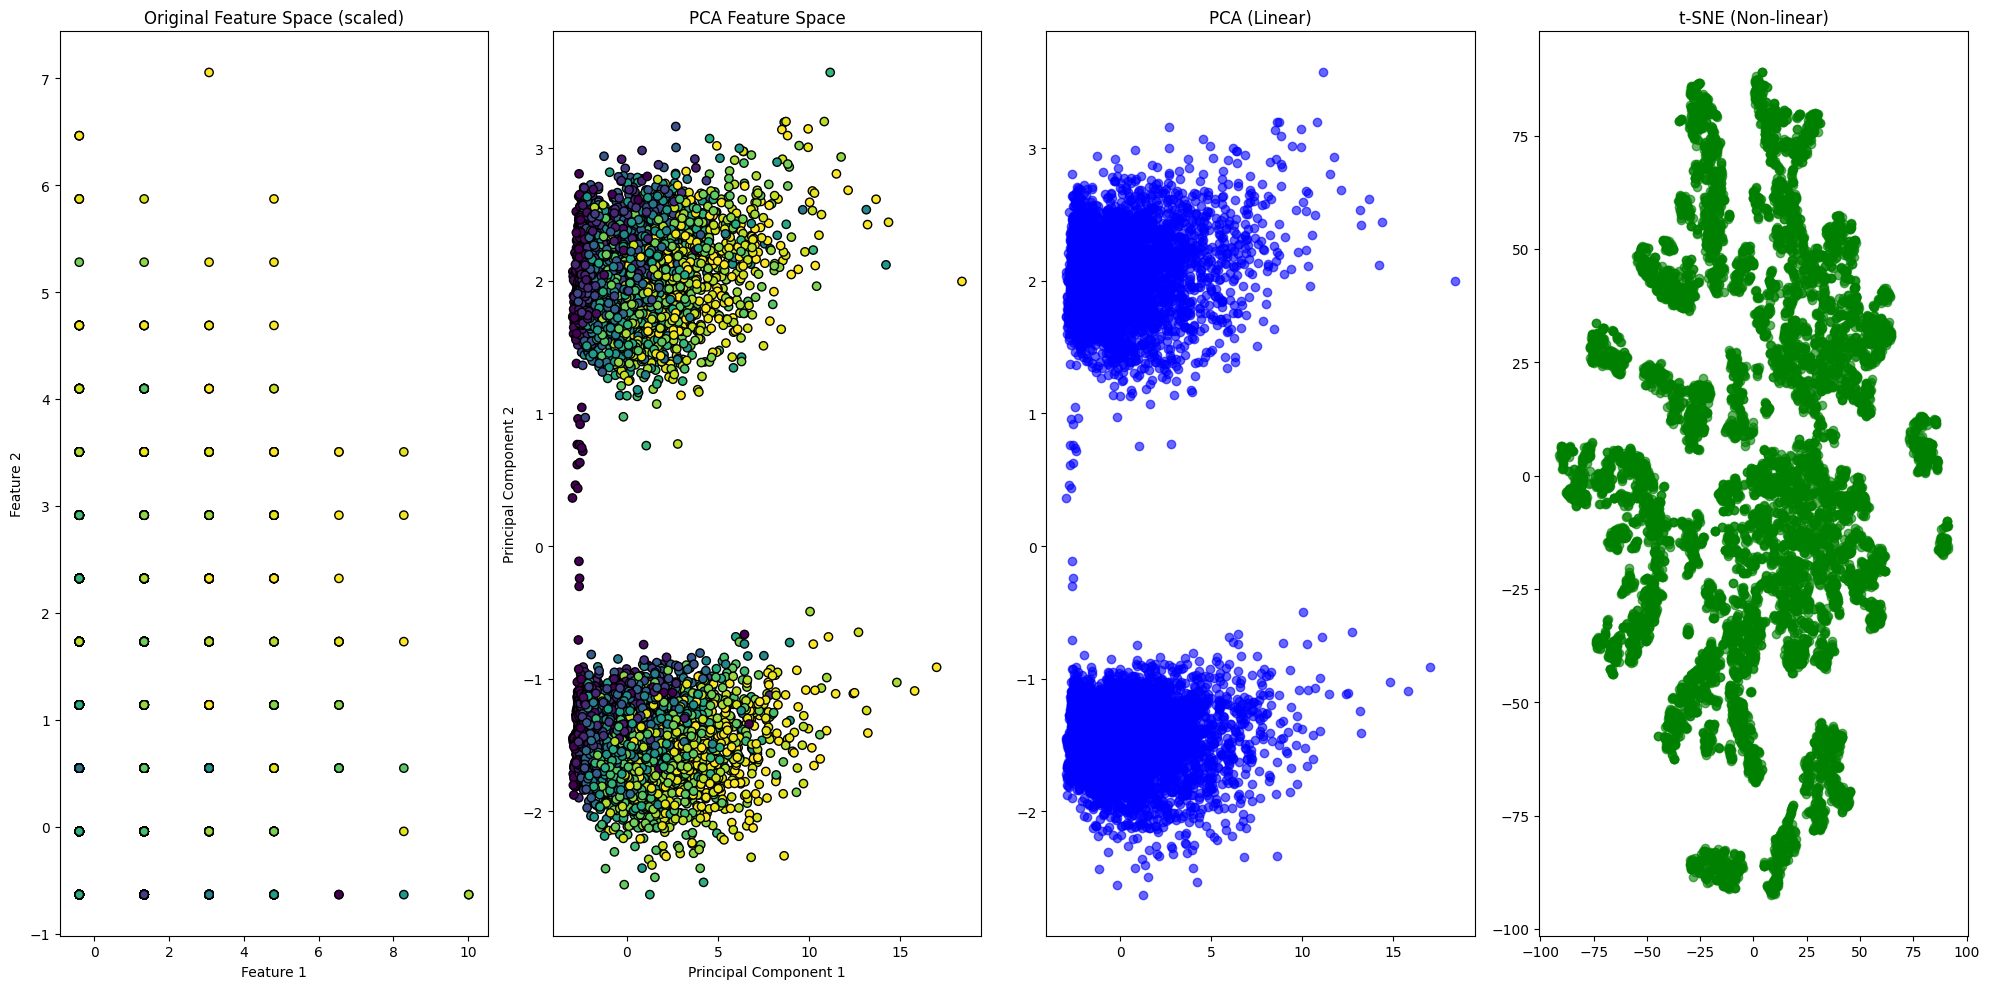

In [ ]:
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


data_sample = train_data.sample(10000, random_state=42)
x_data = data_sample.drop('winPlacePerc', axis=1)
y_data = data_sample['winPlacePerc']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_data)

# 🌈 Apply PCA
# n_components = how many principal components you want to keep after transforming your data.
# if we set n_components to a float between 0 and 1, it will keep enough components to explain that percentage of variance.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_scaled)

# 🔍 Explained variance ratio - percentage of variance explained by each of the selected components
print("Explained variance ratio by each component:")
print(pca.explained_variance_ratio_)

# 🌿 Before PCA: Plot first two original features
plt.figure(figsize=(20, 10))

plt.subplot(1, 4, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_data, cmap='viridis', edgecolor='k')
plt.title('Original Feature Space (scaled)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# 🎯 After PCA: Plot principal components
plt.subplot(1, 4, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_data, cmap='viridis', edgecolor='k')
plt.title('PCA Feature Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plotting - check if my data is linear or non-linear
plt.subplot(1, 4, 3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', alpha=0.6)
plt.title('PCA (Linear)')

plt.subplot(1, 4, 4)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='green', alpha=0.6)
plt.title('t-SNE (Non-linear)')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_35/565737349.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axis[0].scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.6, cmap='Spectral')
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


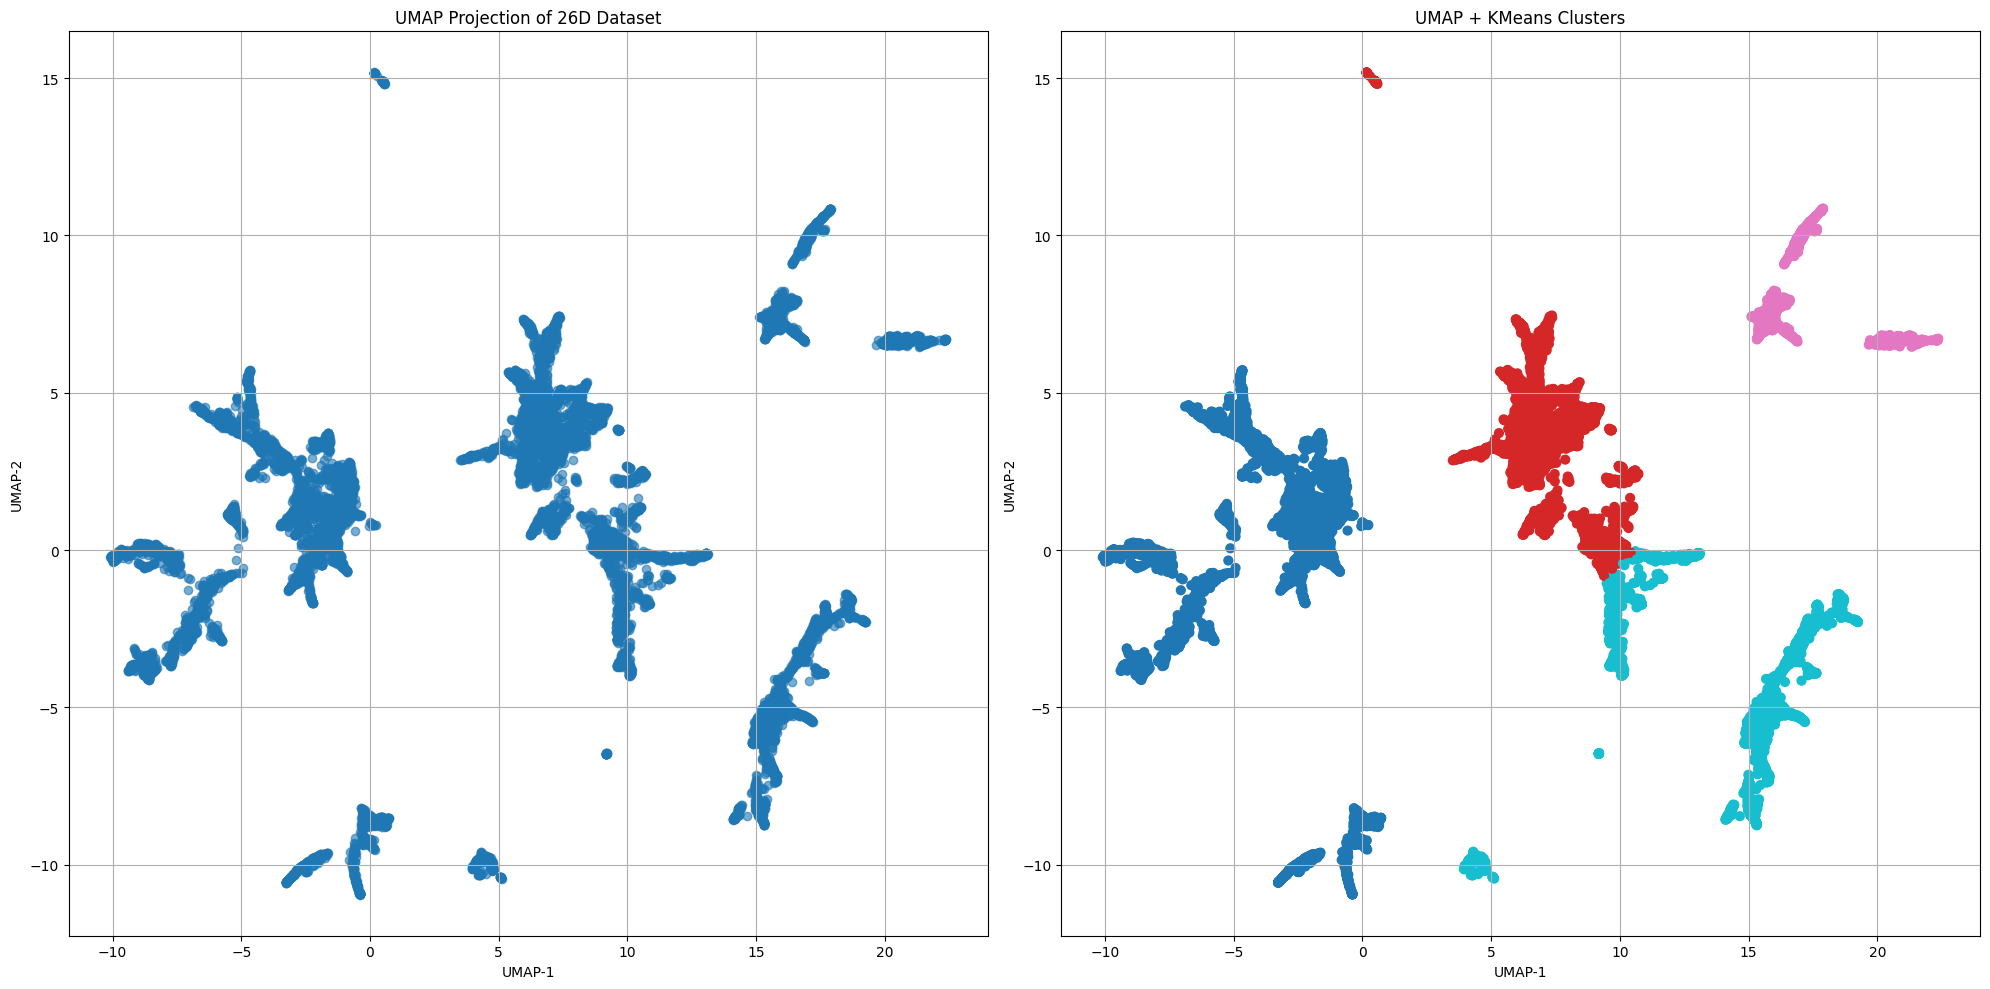

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_data)  # Replace X with your feature matrix

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

fig, axis = plt.subplots(1, 2, figsize=(20, 10))

# First subplot: UMAP projection
axis[0].scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.6, cmap='Spectral')
axis[0].set_title("UMAP Projection of 26D Dataset")
axis[0].set_xlabel("UMAP-1")
axis[0].set_ylabel("UMAP-2")
axis[0].grid(True)

# Second subplot: UMAP + KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_umap)

axis[1].scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab10', s=40)
axis[1].set_title("UMAP + KMeans Clusters")
axis[1].set_xlabel("UMAP-1")
axis[1].set_ylabel("UMAP-2")
axis[1].grid(True)

plt.tight_layout()
plt.show()

# Modeling

## **XGBoost**

### **XGBoost most important parameters**
| Parameter | Description | Under/Overfitting Impact | Priority | Typical Values | When to Adjust | Key Notes |
|-----------|-------------|-------------------------|----------|----------------|----------------|-----------|
| **n_estimators** | Number of boosting rounds (trees) | More trees → overfitting risk<br>Too few → underfitting | 🔴 HIGH | 100-1000 | Always tune first with early stopping | Use early stopping to find optimal point. Start with 100-500 |
| **max_depth** | Maximum depth each tree can grow | Deeper → overfitting (complex patterns)<br>Shallow → underfitting (too simple) | 🔴 HIGH | 3-8 | If model too simple/complex | Most important complexity control. 6+ for complex data, 3-4 for simple |
| **learning_rate** | Shrinkage applied to each tree | Lower → reduces overfitting<br>Higher → faster learning, overfitting risk | 🔴 HIGH | 0.01-0.3 | Balance with n_estimators | Lower rate + more trees = better generalization. 0.1 is good start |
| **reg_alpha (L1)** | L1 regularization on leaf weights | Higher → less overfitting<br>Promotes feature sparsity | 🟡 MEDIUM | 0-10 | Many irrelevant features | Creates sparse models. Good for feature selection |
| **reg_lambda (L2)** | L2 regularization on leaf weights | Higher → less overfitting<br>Smooths extreme weights | 🟡 MEDIUM | 1-10 | Model overfitting | Default 1 is often good. Increase if still overfitting after other tuning |
| **subsample** | Fraction of training samples per tree | Lower → less overfitting<br>Too low → underfitting | 🟡 MEDIUM | 0.7-1.0 | Large datasets, overfitting | Introduces randomness. 0.8-0.9 often optimal |
| **colsample_bytree** | Fraction of features used per tree | Lower → less overfitting<br>Reduces feature correlation | 🟡 MEDIUM | 0.7-1.0 | High-dimensional data | Especially useful with correlated features. Try 0.8 first |
| **min_child_weight** | Min sum of weights required for leaf | Higher → prevents overfitting<br>Requires statistical significance | 🟢 LOW | 1-10 | Imbalanced/noisy data | Higher values for imbalanced data. Start with 1, increase if overfitting |
| **gamma** | Min loss reduction required for split | Higher → more conservative<br>Prevents unnecessary splits | 🟢 LOW | 0-5 | Trees too deep/complex | Acts as pre-pruning. Increase if max_depth alone isn't enough |
| **scale_pos_weight** | Balance positive/negative class weights | Adjusts class prediction bias | 🔴 HIGH* | neg_samples/pos_samples | Imbalanced classification | *Only for imbalanced data. Essential parameter for class imbalance |

In [ ]:
# Convert data to DMatrix for XGBoost API

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

# Train baseline XGBoost classifier
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.1,
    "max_depth": 6,
    "seed": 42
}
bst = xgb.train(params, dtrain, num_boost_round=50, 
                early_stopping_rounds=5, 
                evals=[(dtrain, "train"), (dtest, "test")], verbose_eval=True)

'''
# 4. Evaluate
y_pred_prob = bst.predict(dtest)
y_pred = y_pred_prob.argmax(axis=1)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=iris.target_names))

# 5. Hyperparameter tuning with scikit-learn API
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", seed=42)
param_grid = {
    "max_depth": [2, 3, 4],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [50, 100, 150],
    "subsample": [0.6, 0.8, 1.0]
}
grid = GridSearchCV(xgb_clf, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

# 6. Feature importance
best = grid.best_estimator_
importances = best.feature_importances_
plt.barh(iris.feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()
'''

## Time Series

In [12]:
# Imports

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Generate sample time series data
np.random.seed(42)
dates = pd.date_range('2020-01-01', '2023-12-31', freq='D')
trend = np.linspace(100, 200, len(dates))
seasonal = 10 * np.sin(2 * np.pi * np.arange(len(dates)) / 365.25)
noise = np.random.normal(0, 5, len(dates))
ts = trend + seasonal + noise

df_series = pd.DataFrame({'date': dates, 'value': ts})
df_series.set_index('date', inplace=True)

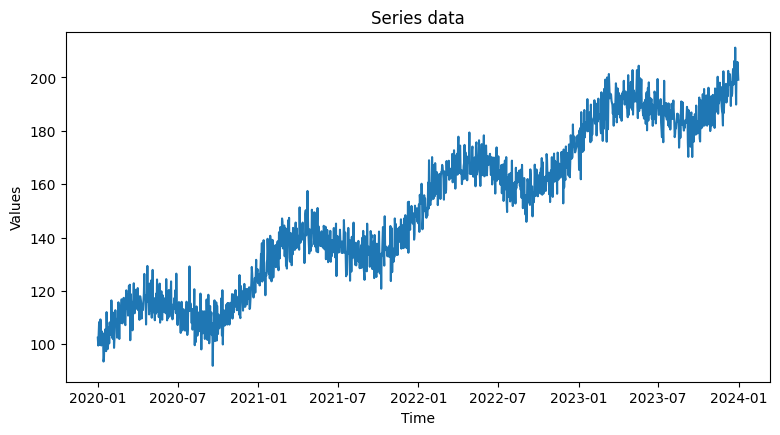

In [10]:
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.plot(df_series.index, df_series.value)
plt.title('Series data')
plt.xlabel('Time')
plt.ylabel('Values')
plt.show()

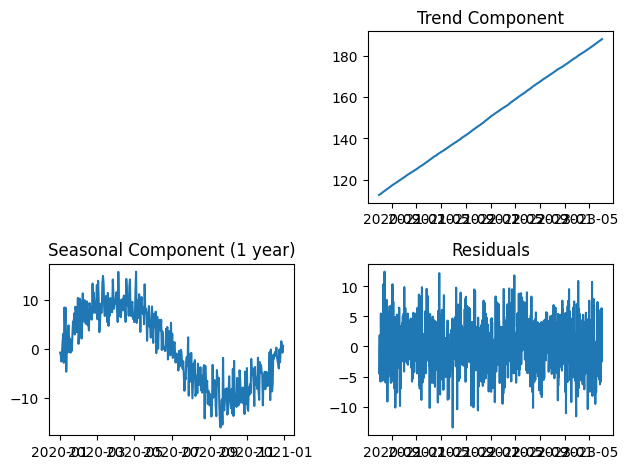

In [13]:
decomposition = seasonal_decompose(df['value'], model='additive', period=365)

plt.subplot(2, 2, 2)
plt.plot(decomposition.trend)
plt.title('Trend Component')

plt.subplot(2, 2, 3)
plt.plot(decomposition.seasonal[:365])  # Show one year of seasonality
plt.title('Seasonal Component (1 year)')

plt.subplot(2, 2, 4)
plt.plot(decomposition.resid)
plt.title('Residuals')

plt.tight_layout()
plt.show()

In [15]:
# 3. STATIONARITY TESTING
def check_stationarity(ts, title):
    print(f"\n=== {title} ===")
    
    # ADF Test
    adf_result = adfuller(ts.dropna())
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print(f"Stationary (ADF): {'Yes' if adf_result[1] < 0.05 else 'No'}")
    
    # KPSS Test
    kpss_result = kpss(ts.dropna())
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")
    print(f"Stationary (KPSS): {'Yes' if kpss_result[1] > 0.05 else 'No'}")

check_stationarity(df['value'], "Original Series")

# Make series stationary through differencing
df_series['diff'] = df_series['value'].diff()
check_stationarity(df_series['diff'], "First Difference")


=== Original Series ===
ADF Statistic: -0.3397
p-value: 0.9197
Stationary (ADF): No
KPSS Statistic: 5.4726
p-value: 0.0100
Stationary (KPSS): No

=== First Difference ===
ADF Statistic: -17.8237
p-value: 0.0000
Stationary (ADF): Yes
KPSS Statistic: 0.1745
p-value: 0.1000
Stationary (KPSS): Yes


In [17]:
# 4. TRAIN-TEST SPLIT
train_size = int(0.8 * len(df))
train = df_series['value'][:train_size]
test = df_series['value'][train_size:]

print(f"\nTrain size: {len(train)}, Test size: {len(test)}")


Train size: 1168, Test size: 293


In [19]:
# 5. FORECASTING MODELS

# Simple Moving Average
def moving_average_forecast(train, test, window=30):
    predictions = []
    for i in range(len(test)):
        if i == 0:
            pred = train.tail(window).mean()
        else:
            # Use last window values from train + previous predictions
            recent_values = list(train.tail(window - i)) + predictions[:i]
            if len(recent_values) >= window:
                recent_values = recent_values[-window:]
            pred = np.mean(recent_values)
        predictions.append(pred)
    print(np.array(predictions))
    return np.array(predictions)

def moving_average_forecast2(train, test, window=30):
    last_window = train[-window:]
    extended_series = pd.concat([pd.Series(last_window), pd.Series([None] * len(test))], ignore_index=True)
    forecast = extended_series.rolling(window=window).mean().iloc[-len(test):]
    print(forecast.values)
    return forecast.values


# Exponential Smoothing (Holt-Winters)
def exponential_smoothing_forecast(train, test):
    model = ExponentialSmoothing(train, 
                                trend='add', 
                                seasonal='add', 
                                seasonal_periods=365)
    fitted_model = model.fit()
    predictions = fitted_model.forecast(len(test))
    return predictions

# ARIMA Model
def arima_forecast(train, test, order=(1,1,1)):
    model = ARIMA(train, order=order)
    fitted_model = model.fit()
    predictions = fitted_model.forecast(len(test))
    return predictions

# Generate predictions
ma_pred = moving_average_forecast(train, test)
ma_pred2 = moving_average_forecast2(train, test)
#es_pred = exponential_smoothing_forecast(train, test)
#arima_pred = arima_forecast(train, test)

[187.52066693 187.51878781 187.49301535 187.62637139 187.47889382
 187.5744629  187.62101824 187.71271107 187.76990223 188.00826644
 188.30590476 188.10181384 188.29201696 188.50689626 188.91694799
 189.08268715 189.36247729 189.15199678 189.03453688 189.19091053
 188.85723813 188.71914663 188.78922972 189.21917683 188.86025113
 189.09805631 189.38179155 189.22577891 188.82391564 188.58020861
 188.46083594 188.4921749  188.52462114 188.559008   188.59009589
 188.62713595 188.66222506 188.69693195 188.72973931 188.76173388
 188.78684946 188.80288095 188.82624986 188.84405762 188.85529633
 188.85324128 188.84559308 188.82836361 188.81757584 188.8103438
 188.79765824 188.79567225 188.7982231  188.79852288 188.78450108
 188.78197608 188.77144007 188.75109502 188.73527223 188.73231745
 188.73738774 188.74660614 188.75508718 188.76276938 188.76956142
 188.77554361 188.78049053 188.78443271 188.7873494  188.78926974
 188.7901876  188.79029887 188.78987947 188.78866713 188.78682078
 188.784538

# Deep Learning

## Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [ ]:
# General syntax:

# Creating tensors
x = torch.tensor([1, 2, 3, 4, 5])  # From list
y = torch.zeros(3, 4)              # Zeros tensor
z = torch.randn(2, 3)              # Random normal distribution
w = torch.ones_like(z)             # Same shape as z, filled with ones

# Tensor properties
print(f"Shape: {z.shape}")         # torch.Size([2, 3])
print(f"Data type: {z.dtype}")     # torch.float32
print(f"Device: {z.device}")       # cpu or cuda

# Mathematical operations
a = torch.tensor([1., 2., 3.])
b = torch.tensor([4., 5., 6.])

addition = a + b                    # Element-wise addition
multiplication = a * b              # Element-wise multiplication
dot_product = torch.dot(a, b)       # Dot product
matrix_mult = torch.mm(a.unsqueeze(0), b.unsqueeze(1))  # Matrix multiplication

# Reshaping and indexing
tensor = torch.randn(4, 4)
reshaped = tensor.view(2, 8)        # Reshape (must maintain total elements)
sliced = tensor[:2, 1:3]           # Slicing like NumPy

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move tensors to GPU
tensor_gpu = tensor.to(device)
# or
tensor_gpu = tensor.cuda()         # If you're sure GPU is available

# Always ensure tensors are on the same device for operations

In [ ]:
# Pytroch Classes
class Iris_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class perceptron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(perceptron, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        output = self.layers(x)
        return output

In [ ]:
# prepare dataset:
iris_data = pd.read_csv('/kaggle/input/iris/Iris.csv')

iris_x = iris_data.drop(['Species', 'Id'], axis=1)

iris_y = iris_data['Species']
iris_y, target = iris_y.factorize()
target_idx = {values: idx for values, idx in enumerate(target)}

# split data to train and test datasets
x_train, x_test, y_train, y_test = train_test_split(iris_x, iris_y, train_size=0.8)

# convert data into tensors
x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

x_test = torch.tensor(x_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


# prepare test and train datasets
train_dataset = Iris_Dataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)

test_dataset = Iris_Dataset(x_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)

In [ ]:
flower_classifier = perceptron(4, 32, 3)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(flower_classifier.parameters(), lr=0.001)

num_epochs = 100
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

flower_classifier.to(device)

for epoch in range(num_epochs):
    # Training phase
    flower_classifier.train()
    running_loss = 0.0
    
    for data, labels in tqdm(train_dataloader, desc='Training loop'):
        # Move inputs and labels to the device
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = flower_classifier(data)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(dataloader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    flower_classifier.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader, desc='Validation loop'):
            # Move inputs and labels to the device
            data, labels = data.to(device), labels.to(device)
         
            outputs = flower_classifier(data)
            loss = loss_func(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(dataloader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

## Loss functions

* **Regression**

| **Loss Function**                  | **Explanation**                                                                   | **Use Case**                                                           | **Outlier Sensitivity** |   |
| ---------------------------------- | --------------------------------------------------------------------------------- | ---------------------------------------------------------------------- | ----------------------- | - |
| **Mean Squared Error (MSE)**       | Penalizes larger errors more than smaller ones by squaring the differences.       | Regression tasks where large errors are undesirable.                   | High                    |   |
| **Mean Absolute Error (MAE)**      | Treats all errors equally by taking the absolute difference.                      | Regression tasks requiring robustness to outliers.                     | Low                     |   |
| **Huber Loss**                     | Combines MSE and MAE; behaves like MSE for small errors and MAE for large errors. | Regression tasks with outliers; balances sensitivity.                  | Medium                  |   |
| **Root Mean Squared Error (RMSE)** | Square root of MSE; maintains the same units as the target variable.              | Regression tasks where interpretability in target units is beneficial. | High                    |   |


* **Classification**

| **Loss Function**                   | **Explanation**                                                                              | **Use Case**                                            | **Outlier Sensitivity** |   |
| ----------------------------------- | -------------------------------------------------------------------------------------------- | ------------------------------------------------------- | ----------------------- | - |
| **Binary Cross-Entropy (Log Loss)** | Measures the performance of a classification model outputting probabilities between 0 and 1. | Binary classification problems.                         | High                    |   |
| **Categorical Cross-Entropy**       | Generalization of binary cross-entropy for multi-class classification problems.              | Multi-class classification with one-hot encoded labels. | High                    |   |
| **Hinge Loss**                      | Used for "maximum-margin" classification, primarily with Support Vector Machines (SVMs).     | Binary classification with SVMs.                        | Medium                  |   |


* **Other**

| **Loss Function**                               | **Explanation**                                                                                                                 | **Use Case**                                                            | **Outlier Sensitivity** |   |
| ----------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------- | ----------------------- | - |
| **Kullback-Leibler Divergence (KL Divergence)** | Measures how one probability distribution diverges from a second, expected probability distribution.                            | Comparing probability distributions; e.g., in variational autoencoders. | High                    |   |
| **Cosine Similarity Loss**                      | Measures the cosine of the angle between two non-zero vectors; assesses similarity.                                             | Text classification and tasks involving high-dimensional vector spaces. | Low                     |   |
| **Triplet Loss**                                | Ensures that the distance between an anchor and a positive example is less than the distance to a negative example by a margin. | Face recognition, metric learning tasks.                                | Medium                  |   |

<br>

When to Use:
<br>

**MSE**: Use when you want to heavily penalize large errors (e.g., forecasting, financial modeling).

**MAE**: Use when all errors should be treated equally, and outliers shouldn't dominate (e.g., evaluating models with noisy data).

**RMSE**: Best when you need a balance between MSE and MAE, keeping errors in the same scale as the original data (e.g., climate modeling, sensor measurements).

## CNN

**How 2D convolution works:**  
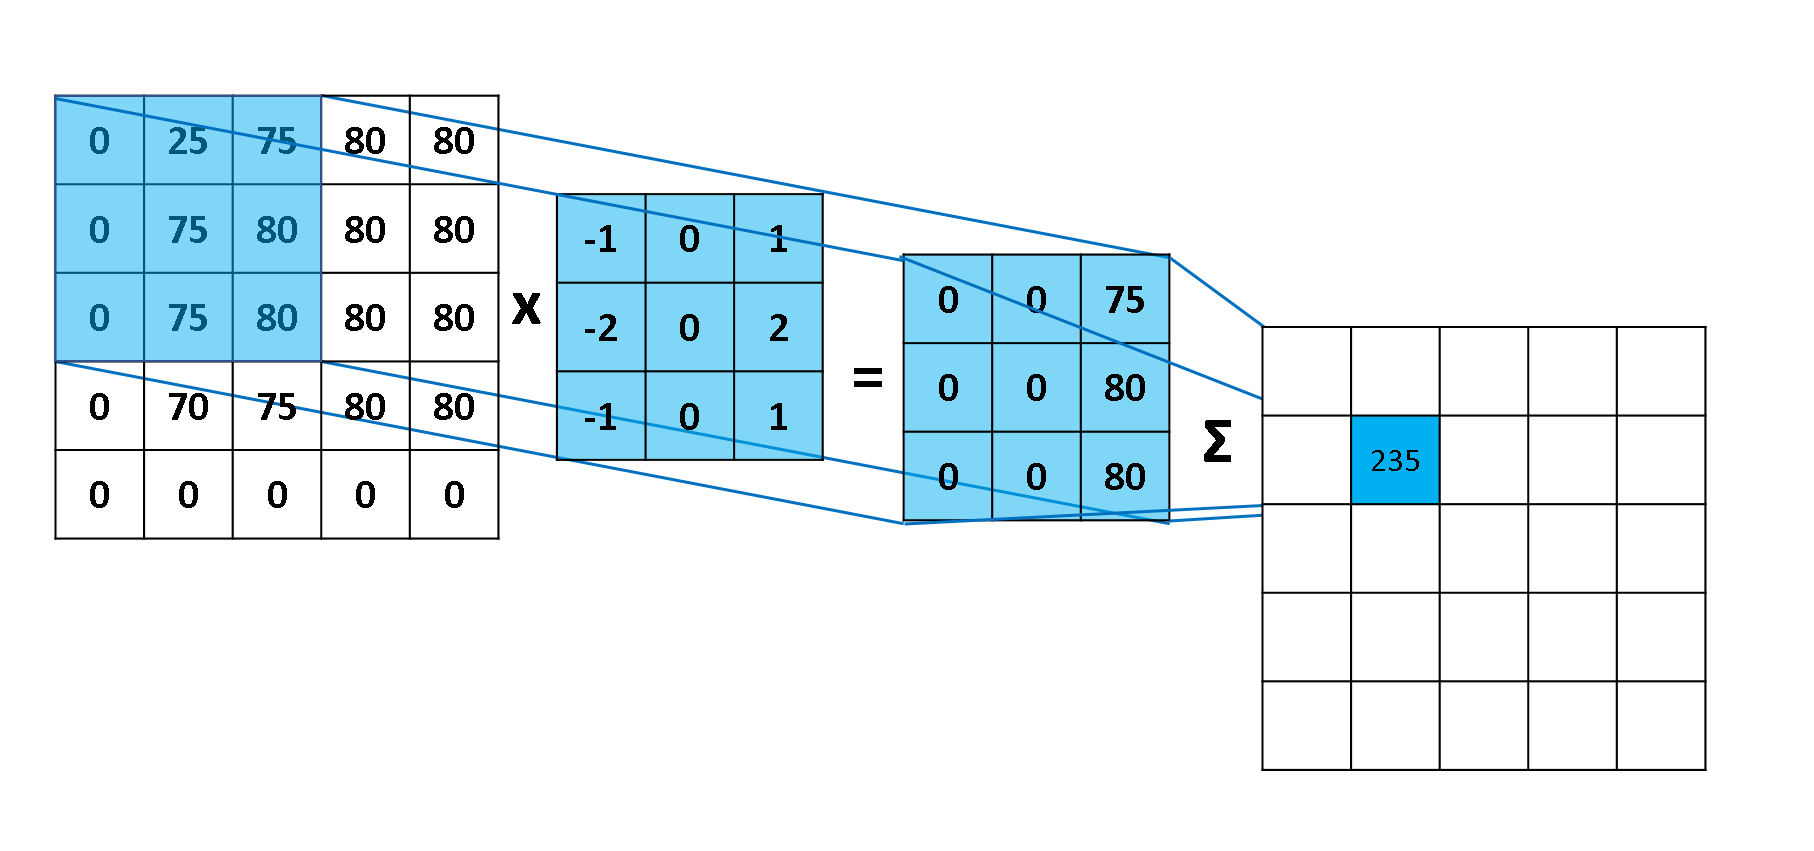

In [1]:
# imports
import cv2
import glob
import json
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms
from matplotlib.patches import Rectangle
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

### CV2

#### Loading image

In [2]:
flowers_path = r'/kaggle/input/flowers-recognition/flowers'
images = glob.glob(f"{flowers_path}/rose/*.jpg")

In [ ]:
# IMAGE SCALING AND NORMALIZATION
# Deep learning models expect consistent input sizes and value ranges
resized = cv2.resize(img_rgb, (224, 224))  # Common size for many models
normalized = resized.astype(np.float32) / 255.0  # Scale to [0,1] range

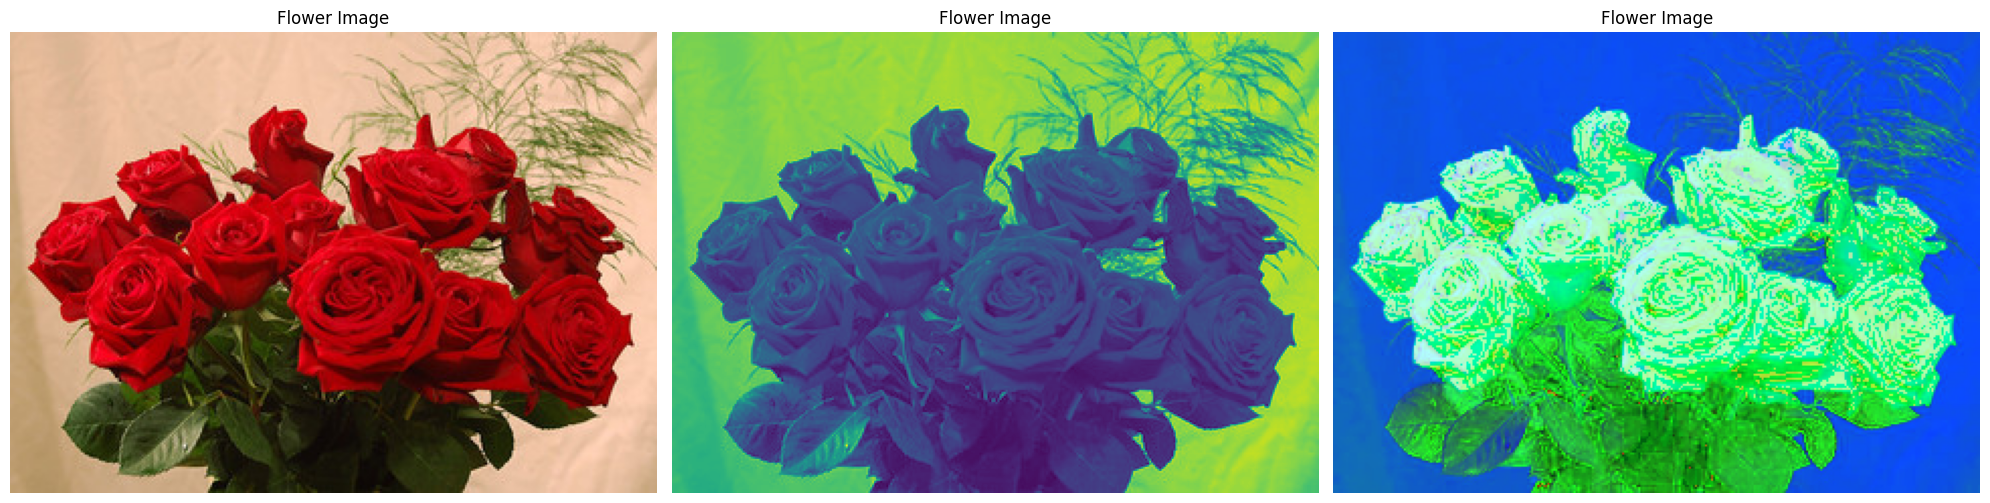

In [3]:
# load image
flower_path = '/kaggle/input/flowers-recognition/flowers/rose/2265390547_2409007cef_n.jpg'

img = cv2.imread(flower_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

fig, axis = plt.subplots(1, 3, figsize=(20,10))

axis[0].imshow(img_rgb)
axis[0].axis('off')
axis[0].set_title('Flower Image')

axis[1].imshow(gray_image) # Grayscale: Reduces complexity, good for shape detection
axis[1].axis('off')
axis[1].set_title('Flower Image')

axis[2].imshow(hsv_image) # HSV: Better for color-based object detection
axis[2].axis('off')
axis[2].set_title('Flower Image')

plt.tight_layout()
plt.show()

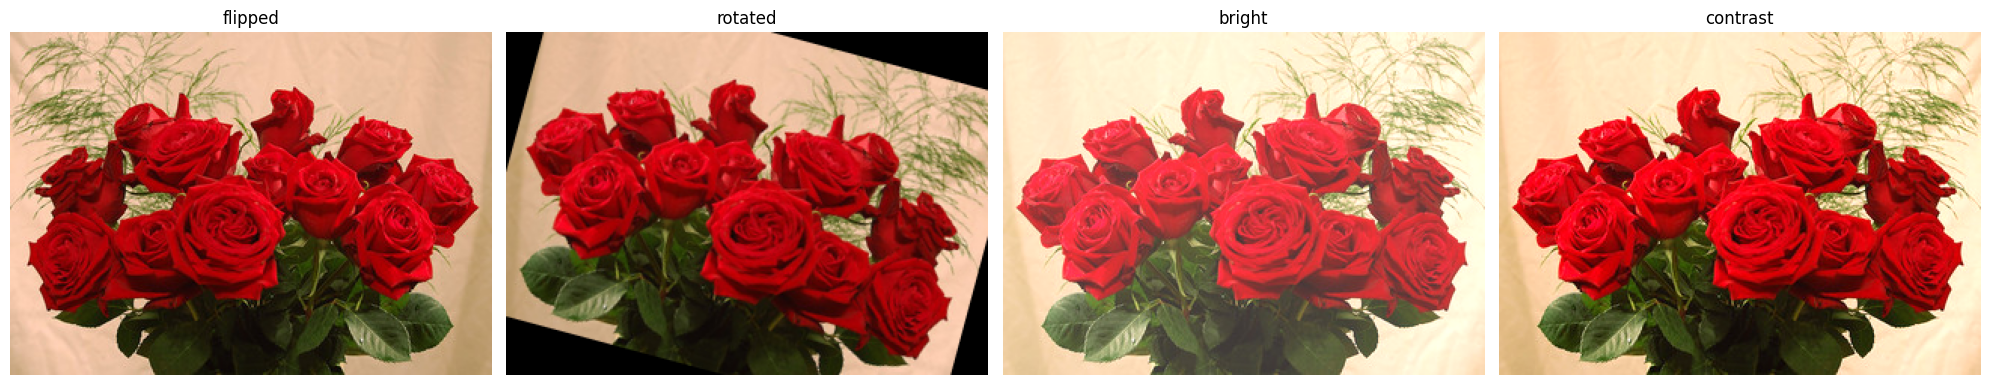

In [ ]:
# Additional image augmentation techniques
# Flip horizontally
flipped = cv2.flip(img_rgb, 1)  # 0=vertical, 1=horizontal, -1=both axes

# Rotate (e.g., 15 degrees clockwise around center)
(h, w) = img_rgb.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, -15, 1.0)
rotated = cv2.warpAffine(img_rgb, M, (w, h))

# Brightness adjustment (increase)
bright = cv2.convertScaleAbs(img_rgb, alpha=1.0, beta=50)  # beta is brightness

# Contrast adjustment (increase slightly)
contrast = cv2.convertScaleAbs(img_rgb, alpha=1.2, beta=0)  # alpha is contrast

fig, axis = plt.subplots(1, 4, figsize=(20,10))

axis[0].imshow(flipped)
axis[0].axis('off')
axis[0].set_title('flipped')

axis[1].imshow(rotated)
axis[1].axis('off')
axis[1].set_title('rotated')

axis[2].imshow(bright)
axis[2].axis('off')
axis[2].set_title('bright')

axis[3].imshow(contrast)
axis[3].axis('off')
axis[3].set_title('contrast')

plt.tight_layout()
plt.show()

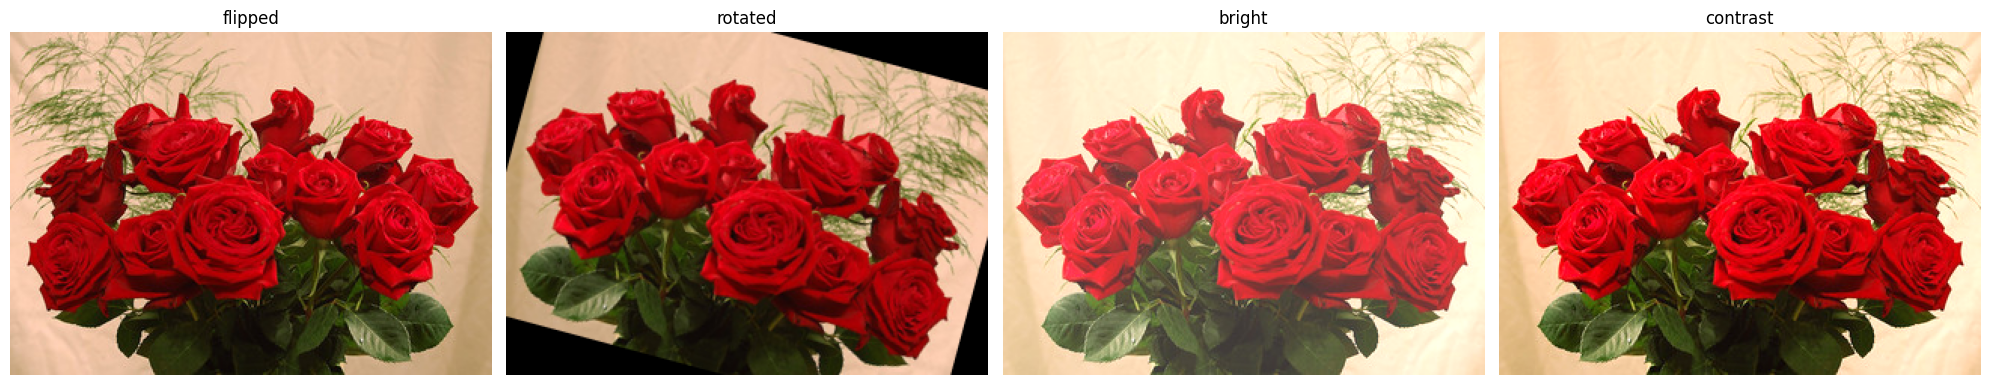

In [ ]:
# Additional image augmentation techniques
# Flip horizontally
flipped = cv2.flip(img_rgb, 1)  # 0=vertical, 1=horizontal, -1=both axes

# Rotate (e.g., 15 degrees clockwise around center)
(h, w) = img_rgb.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, -15, 1.0)
rotated = cv2.warpAffine(img_rgb, M, (w, h))

# Brightness adjustment (increase)
bright = cv2.convertScaleAbs(img_rgb, alpha=1.0, beta=50)  # beta is brightness

# Contrast adjustment (increase slightly)
contrast = cv2.convertScaleAbs(img_rgb, alpha=1.2, beta=0)  # alpha is contrast

fig, axis = plt.subplots(1, 4, figsize=(20,10))

axis[0].imshow(flipped)
axis[0].axis('off')
axis[0].set_title('flipped')

axis[1].imshow(rotated)
axis[1].axis('off')
axis[1].set_title('rotated')

axis[2].imshow(bright)
axis[2].axis('off')
axis[2].set_title('bright')

axis[3].imshow(contrast)
axis[3].axis('off')
axis[3].set_title('contrast')

plt.tight_layout()
plt.show()

#### Data augmentation

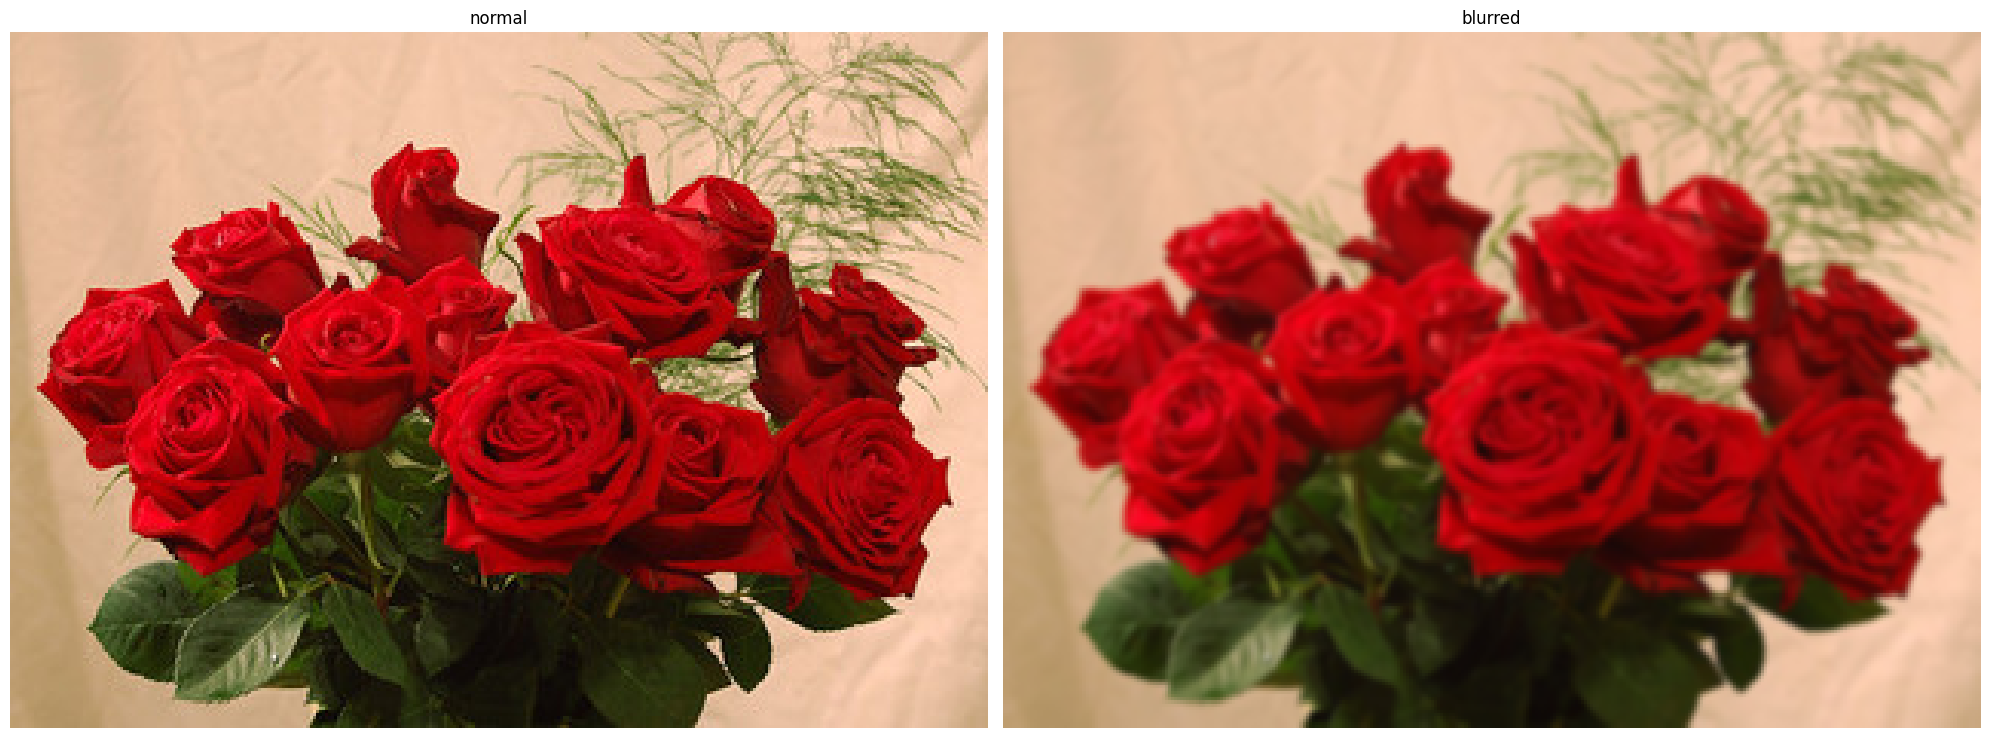

In [18]:
# Real-world images always have noise - this is crucial preprocessing
blurred = cv2.GaussianBlur(img_rgb, (5, 5), 0)

fig, axis = plt.subplots(1, 2, figsize=(20,10))

axis[0].imshow(img_rgb)
axis[0].axis('off')
axis[0].set_title('normal')

axis[1].imshow(blurred)
axis[1].axis('off')
axis[1].set_title('blurred')

plt.tight_layout()
plt.show()

#### ROI detection

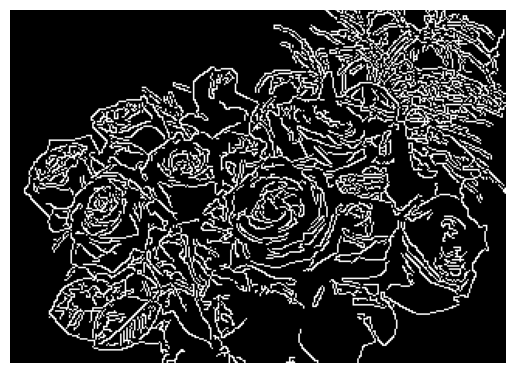

In [ ]:
# Edges contain most of the structural information in images
edges = cv2.Canny(gray_image, 50, 150)

plt.plot(figsize=(20,10))
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()

1122


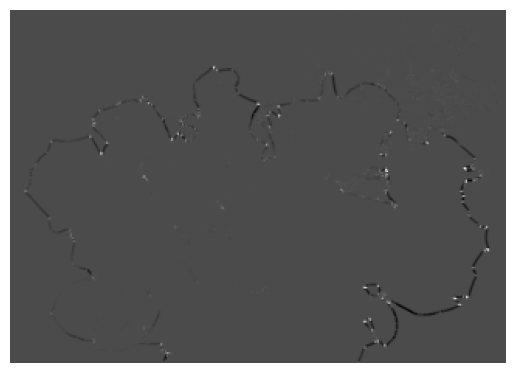

In [24]:
# HARRIS CORNER DETECTION
# Corners are stable features that don't change much with rotation/scaling
gray_image = gray_image.astype(np.float32)
corners = cv2.cornerHarris(gray_image, 2, 3, 0.04)
corner_count = np.sum(corners > 0.01 * corners.max())
print(corner_count)

plt.plot(figsize=(20,10))
plt.imshow(corners, cmap='gray')
plt.axis('off')
plt.show()

#### Keypoints:

- Specific, visually distinctive locations in an image—like corners, edges, or blobs.
- They represent **areas of interest** that algorithms can track, compare, or describe.
- Think of them as the "landmarks" of an image—places that stand out and stay consistent even if the image is rotated, scaled, or slightly changed.

🧠 Why They Matter

- Keypoints help in tasks like **object recognition**, **image matching**, and **motion tracking**.
- They’re used to build **descriptors**, which are compact representations of the image’s features.

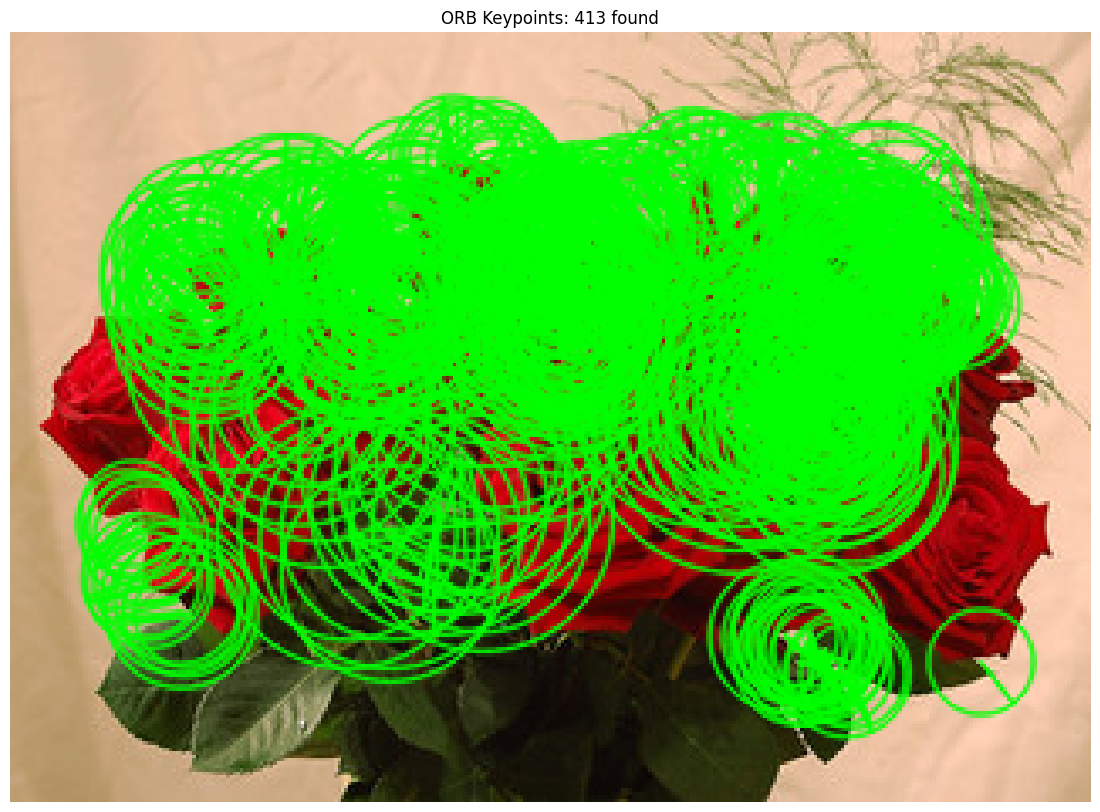

In [34]:
# ORB FEATURE DETECTION
# ORB finds keypoints and describes them with binary descriptors
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(img_rgb, None)

# Draw keypoints on image
img_with_keypoints = cv2.drawKeypoints(img_rgb, keypoints, None, color=(0, 255, 0),
                                       flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(20,10))
plt.imshow(img_with_keypoints)
plt.axis('off')
plt.title(f"ORB Keypoints: {len(keypoints)} found")
plt.show()

### Create dataset

In [4]:
# transform data to fit CNN
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
    ])

flowers_path = r'/kaggle/input/flowers-recognition/flowers'
dataset = ImageFolder(root=flowers_path, transform=transform)

# Calculate lengths
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Randomly split
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Create loaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16)

### Model creation

In [4]:
class TestCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(TestCNN, self).__init__()

        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.norm1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.norm2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.norm3 = nn.BatchNorm2d(64)

        # Fully connected layers
        self.fc = nn.Linear(64 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.norm2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.norm3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        
        # Classifier
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### Training

In [ ]:
# training
EPOCHS = 8

flower_classifier = TestCNN()

train_loss, val_loss = [], []
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(flower_classifier.parameters())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
flower_classifier.to(device)

for epoch in range(EPOCHS):
    flower_classifier.train()
    running_loss = 0

    # training
    for data, labels in tqdm(train_loader, desc='Training loop'):
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()
        output = flower_classifier(data)
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)

    train_loss.append(running_loss / len(train_loader.dataset))

    # evaluation
    flower_classifier.eval()
    running_loss = 0

    with torch.no_grad():
        for data, labels in tqdm(val_loader, desc='Validation loop'):
            data, labels = data.to(device), labels.to(device)

            output = flower_classifier(data)
            loss = loss_func(output, labels)
            running_loss += loss.item() * labels.size(0)
        
        val_loss.append(running_loss / len(val_loader.dataset))
        print(f'Epoch: {epoch} \ntraining loss: {train_loss} \nvalidation loss: {val_loss}')

Validation loop: 100%|██████████| 41/41 [00:01<00:00, 22.20it/s]


Epoch: 0 
training loss: [1.2787023446923729] 
validation loss: [1.1413020026370584]


Validation loop: 100%|██████████| 41/41 [00:01<00:00, 22.43it/s]


Epoch: 1 
training loss: [1.2787023446923729, 1.0886069130163563] 
validation loss: [1.1413020026370584, 1.0490469698559557]


Validation loop: 100%|██████████| 41/41 [00:01<00:00, 22.97it/s]


Epoch: 2 
training loss: [1.2787023446923729, 1.0886069130163563, 1.0309428050793468] 
validation loss: [1.1413020026370584, 1.0490469698559557, 0.9739102053310624]


Training loop:  58%|█████▊    | 109/189 [00:05<00:04, 19.34it/s]

### Inference

In [ ]:
test_img = Image.open(r'/kaggle/input/flowers-recognition/flowers/daisy/100080576_f52e8ee070_n.jpg').convert('RGB')
test_img = transform(test_img).unsqueeze(0)

# after 2 epochs - [0.1209, 0.3016, 0.0307, 0.4907, 0.0561]
# after 5  epochs - [0.2535, 0.3500, 0.0598, 0.2638, 0.0729]

with torch.no_grad():
    output = flower_classifier(test_img)
    probs = torch.softmax(output, dim=1)
    prediction = torch.argmax(probs)
print(dataset.classes)
print(probs)
print(dataset.classes[int(prediction)])

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
tensor([[0.2535, 0.3500, 0.0598, 0.2638, 0.0729]])
dandelion


### Gradient Descent - Visualization

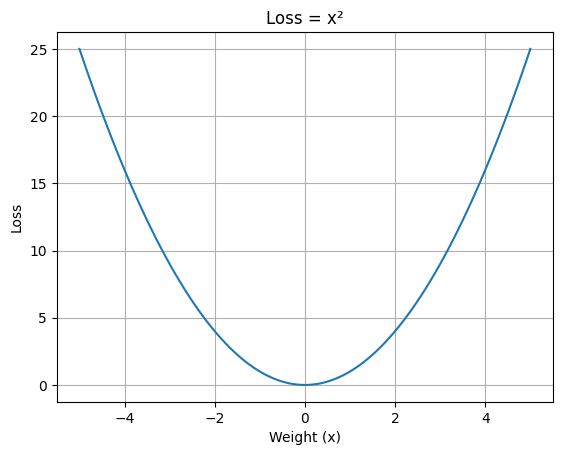

In [6]:
import torch
import matplotlib.pyplot as plt

# Create some x values and a sample loss curve
x = torch.linspace(-5, 5, 100, requires_grad=True)
y = x**2  # a simple loss function: y = x²

plt.plot(x.detach(), y.detach())
plt.title("Loss = x²")
plt.xlabel("Weight (x)")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


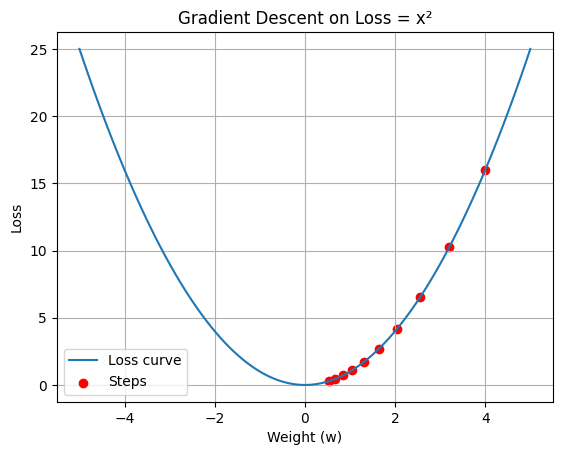

In [7]:
# Start somewhere on the hill (initial weight)
w = torch.tensor([4.0], requires_grad=True)

# Simulate steps down the hill
lr = 0.1  # learning rate
trajectory = []

for step in range(10):
    loss = w**2                  # simple loss function
    loss.backward()              # compute gradient (dL/dw)
    
    with torch.no_grad():
        trajectory.append((w.item(), loss.item()))
        w -= lr * w.grad         # take a step downhill
        w.grad.zero_()           # reset gradients

# Plot the path taken down the hill
x_vals = [pt[0] for pt in trajectory]
y_vals = [pt[1] for pt in trajectory]

plt.plot(x.detach(), y.detach(), label="Loss curve")
plt.scatter(x_vals, y_vals, color='red', label="Steps")
plt.title("Gradient Descent on Loss = x²")
plt.xlabel("Weight (w)")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


### Mask R-CNN

**Mask R-CNN** (Mask Region-based Convolutional Neural Network) is a powerful deep learning architecture that extends Faster R-CNN to solve instance segmentation problems. While **object detection** tells you "where" objects are with bounding boxes, **instance segmentation** goes further by telling you the exact pixel-level boundaries of each object instance.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


dict_keys(['boxes', 'labels', 'scores', 'masks'])


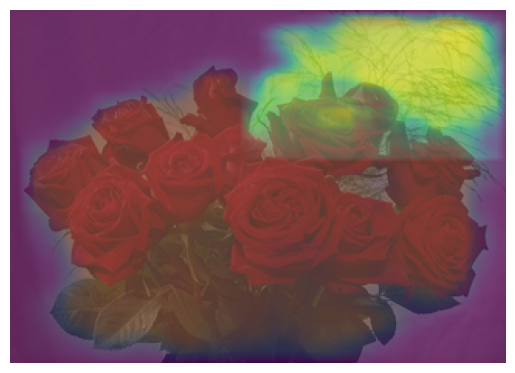

In [ ]:
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt

# 1. Load the pretrained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # inference mode

#img, target = dataset[0]
img = F.to_tensor(img_rgb)

# 3. Run inference
with torch.no_grad():
    prediction = model([img])

# 4. Show predictions
print(prediction[0].keys())  # ['boxes', 'labels', 'scores', 'masks']

# Example: visualize masks above confidence threshold
plt.imshow(img.permute(1, 2, 0))
for i, score in enumerate(prediction[0]['scores']):
    if score > 0.7:  # keep only high confidence
        mask = prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()
        plt.imshow(mask, alpha=0.5)
plt.axis("off")
plt.show()

### SAM (Segment Anything Model)

| Aspect                  | Description                                                                                                                                                                                                                                                                                           |
| ----------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **What it is**          | A **class-agnostic, promptable segmentation model** from Meta AI (2023). It can cut out **any object** from an image using a simple prompt like a point, box, or text.                                                                                                                                |
| **How it works** | 1️⃣ **Image Encoder:** Turns the image into features (like a compressed “map” of the image). <br>2️⃣ **Prompt Encoder:** Encodes your hint—e.g., a mouse click on a dog’s ear or a bounding box. <br>3️⃣ **Mask Decoder:** Combines the two to predict a mask that outlines the object’s exact shape. |
| **Practical Example**   | 🐶📸 You upload a photo of a dog on a couch. Click anywhere on the dog → SAM instantly returns a perfect cut-out of the dog’s silhouette, even if the couch pattern is complicated or the dog breed wasn’t in its training set.                                                                       |
| **Pros ✅**              | • Works on **any object**, even unseen categories. <br>• **Fast** and interactive—ideal for annotation tools. <br>• Handles complex boundaries (fur, overlapping objects). <br>• Scales well because the image encoding can be reused for multiple prompts.                                           |
| **Cons ❌**              | • **Doesn’t label** objects (it won’t tell you “this is a dog”—just gives the mask). <br>• Large model—**heavy on compute and memory**. <br>• Best with some human guidance or external prompts (not fully automatic detection).                                                                      |


## LLM

In [ ]:
# imports

import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from trl import DPOTrainer
from datasets import Dataset
from nltk.tokenize import word_tokenize
from peft import LoraConfig, get_peft_model
from nltk.translate.bleu_score import sentence_bleu
from sentence_transformers import SentenceTransformer
from transformers import (
        GPT2LMHeadModel, 
        GPT2Tokenizer, 
        AutoModelForCausalLM, 
        AutoTokenizer, 
        Trainer, 
        TrainingArguments
        )

TF-IDF stands for Term Frequency–Inverse Document Frequency.  
It’s a classic method used to figure out how important a word is in a document compared to a whole collection of documents.  

*It’s made of two parts:*  
  
**TF (Term Frequency)**: How often a word appears in a document.  
Example: If “bolter” appears 5 times in a 100-word document → TF = 5/100 = 0.05

**IDF (Inverse Document Frequency)**: How rare the word is across all documents.  
If “bolter” appears in only 2 out of 100 documents → IDF = log(100 / 2) ≈ 1.7

### Attention mechanism

| Step | Action                        | What Happens                                                                                | Mini‑Example                               |
| :--: | ----------------------------- | ------------------------------------------------------------------------------------------- | ------------------------------------------ |
|   1  | Tokenize & Embed              | Split sequence into tokens; map each to a d‑dim vector                                      | “I love NLP” → \[v₁, v₂, v₃]               |
|   2  | Project to Q and K            | Compute **Q**, and **K**                                     | **Qᵢ** = V_Q·Vᵢ,  **Kⱼ** = V_K·Vⱼ|
|   3  | Score & Scale                 | For each query Qᵢ, compute raw score sᵢⱼ = Qᵢ·Kⱼᵀ; divide by √(d\_k) to stabilize gradients | s₁₂ = Q₁·K₂ᵀ / √d_k                          |
|   4  | Softmax to Weights            | Normalize scores into attention weights aᵢ = softmax(sᵢ) (we want probabilities)                                  | a₁ = \[0.2, 0.7, 0.1]                      |
|   5  | Weighted Sum → Context Vector | Compute **cᵢ = ∑ⱼ aᵢⱼ·Vⱼ** - This produces an updated token representation by aggregating information from all Vectors                            | c₁ = 0.2·V₁ + 0.7·V₂ + 0.1·V₃              |
|   6  | (Opt.) Multi‑Head & Combine   | Repeat in H “heads” with different W\_Q/W\_K/W\_V; concat & project → richer representation | head₁(c), head₂(c), … → concat → final     |


**Q** - Query - ask “what am I looking for?” at each position (i).  
**K** - Keys - answer “what do I have?” at every **other** position (j).  
**V** - Values - Values with which we **update** our token vector ((softmax of Q·K) · **V**alues_vector)

### Fine tunning:

| Rank | Method                                   | What it is (1-line)                                                       | Data / signal                       | Complexity & compute                     | Main pros                                               | Main cons                                                  |
| ---: | ---------------------------------------- | ------------------------------------------------------------------------- | ----------------------------------- | ---------------------------------------- | ------------------------------------------------------- | ---------------------------------------------------------- |
|    1 | **Self-Supervised Fine-Tuning (SSFT)**   | Continue pretraining on *unlabeled* domain text to adapt knowledge.       | Raw text corpus from target domain. | Medium–high compute, simple pipeline.    | No labels needed; great for domain knowledge injection. | Doesn’t enforce specific behaviors; needs later alignment. |
|    2 | **SFT + LoRA/PEFT**                      | Fine-tune with labeled `(prompt → output)` data using small adapters.     | Labeled instruction/response pairs. | Low–medium compute, very cost-efficient. | Strong control over output; cheap & fast iterations.    | Needs quality labeled data; narrow if dataset small.       |
|    3 | **Direct Preference Optimization (DPO)** | Align LM to human preferences from A/B choice data, no RL loop.           | Human comparison pairs.             | Medium compute, stable training.         | Matches/exceeds RLHF in many cases; simpler.            | Still requires preference annotations.                     |
|    4 | **Prompt Engineering**                   | Steering model via crafted instructions/examples at inference.            | None — only prompt text.            | Zero training cost.                      | Instant, free, works with any model.                    | Brittle; can’t fix model’s core knowledge gaps.            |
|    5 | **RLHF**                                 | Learn a reward model from human prefs, then optimize policy via RL (PPO). | Human comparison pairs + RL loop.   | High complexity & compute.               | Very flexible; fine-grained alignment.                  | Expensive, unstable; replaced by DPO for most teams.       |


Key points & practical notes:
* Typical modern pipeline → **SSFT → SFT+LoRA → DPO → Prompt engineering**. **RLHF** is optional for large-budget orgs.

* **SSFT** = best for injecting domain knowledge before any alignment. Example: adapting base LLM to legal or biomedical text.

* **SFT + LoRA** = cheapest way to make instruction-following specialists. Often paired with synthetic data to reduce labeling costs.

* **DPO** is rapidly replacing RLHF for preference alignment: fewer moving parts, more stable, competitive performance.

* **Prompt engineering** is always useful, but in 2025 it’s more like the final polish layer rather than a full tuning strategy.

* **Full SFT without LoRA** is rare now except in research or when cost is not an issue — adapters dominate for efficiency.

* Combining **SSFT + SFT + DPO** yields models that are knowledgeable, task-specific, and aligned without huge budgets.

In [ ]:
MODEL_NAME = "gpt2"  # small demo model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# pip install transformers datasets peft trl

# -------------------------------------------------------------------------
# 1. SELF-SUPERVISED FINE-TUNING (SSFT) - Domain adaptation
# -------------------------------------------------------------------------
raw_texts = ["Legal text example...", "Medical document...", "Technical article..."]
ssft_dataset = Dataset.from_dict({"text": raw_texts})
ssft_dataset = ssft_dataset.map(lambda x: tokenizer(x["text"], truncation=True, padding="max_length"), batched=True)

model_ssft = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
trainer_ssft = Trainer(
    model=model_ssft,
    args=TrainingArguments("ssft_out", per_device_train_batch_size=2, num_train_epochs=1),
    train_dataset=ssft_dataset
)
# trainer_ssft.train()  # Uncomment to run

# -------------------------------------------------------------------------
# 2. FULL SFT (fine-tune all parameters)
# -------------------------------------------------------------------------
sft_data = [
    {"prompt": "Translate to French: Hello", "completion": "Bonjour"},
    {"prompt": "Summarize: The cat sat on the mat.", "completion": "A cat on a mat."}
]
dataset_full_sft = Dataset.from_dict({
    "text": [f"{ex['prompt']} {ex['completion']}" for ex in sft_data]
})
dataset_full_sft = dataset_full_sft.map(lambda x: tokenizer(x["text"], truncation=True, padding="max_length"), batched=True)

model_full_sft = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
trainer_full_sft = Trainer(
    model=model_full_sft,
    args=TrainingArguments("full_sft_out", per_device_train_batch_size=2, num_train_epochs=1, save_strategy="no"),
    train_dataset=dataset_full_sft
)
# trainer_full_sft.train()  # Uncomment to run

# -------------------------------------------------------------------------
# 3. SFT + LoRA (combined example from earlier snippet)
# -------------------------------------------------------------------------
sft_dataset_combined = Dataset.from_dict({
    "text": [f"{ex['prompt']} {ex['completion']}" for ex in sft_data]
})
sft_dataset_combined = sft_dataset_combined.map(lambda x: tokenizer(x["text"], truncation=True, padding="max_length"), batched=True)

model_sft_lora_combo = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
lora_config_combo = LoraConfig(r=8, lora_alpha=16, target_modules=["c_attn"], lora_dropout=0.05)
model_sft_lora_combo = get_peft_model(model_sft_lora_combo, lora_config_combo)

trainer_combo = Trainer(
    model=model_sft_lora_combo,
    args=TrainingArguments("sft_combo_out", per_device_train_batch_size=2, num_train_epochs=1),
    train_dataset=sft_dataset_combined
)
# trainer_combo.train()  # Uncomment to run

# -------------------------------------------------------------------------
# 4. DIRECT PREFERENCE OPTIMIZATION (DPO)
# -------------------------------------------------------------------------
dpo_data = Dataset.from_dict({
    "prompt": ["Tell a joke about cats"],
    "chosen": ["Why did the cat sit on the computer? To keep an eye on the mouse!"],
    "rejected": ["Cats are animals."]
})

model_dpo = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
dpo_trainer = DPOTrainer(
    model=model_dpo,
    args=TrainingArguments("dpo_out", per_device_train_batch_size=1, num_train_epochs=1),
    beta=0.1,
    train_dataset=dpo_data,
    tokenizer=tokenizer
)
# dpo_trainer.train()  # Uncomment to run

# -------------------------------------------------------------------------
# 5. PROMPT ENGINEERING (no training)
# -------------------------------------------------------------------------
model_prompt = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
prompt = """You are a helpful assistant.
Input: "Gotta go now."
Output:"""
inputs = tokenizer(prompt, return_tensors="pt")
# output = model_prompt.generate(**inputs, max_new_tokens=20)
# print(tokenizer.decode(output[0]))

# -------------------------------------------------------------------------
# 6. RLHF (pseudo-code, not runnable here)
# -------------------------------------------------------------------------
"""
# Step 1: Train reward model
reward_model = train_reward_model(human_comparison_data)

# Step 2: RL fine-tuning with PPO
ppo_trainer = PPOTrainer(model=policy_model, ref_model=base_model,
                         reward_model=reward_model, ...)
ppo_trainer.train()
"""

print("All fine-tuning method examples prepared. Uncomment .train() calls to run them.")


### Text generation

In [19]:
class TextGenerationExample:
    """
    Practical example of using pre-trained models for text generation.
    This is what you'll commonly work with in real GenAI applications.
    """
    
    def __init__(self, model_name="gpt2"):
        # Load pre-trained model and tokenizer
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.model = GPT2LMHeadModel.from_pretrained(model_name, )
        
        # Set padding token (GPT2 doesn't have one by default)
        self.tokenizer.pad_token = self.tokenizer.eos_token
    
    def generate_text(self, prompt, max_length=50, temperature=0.7):
        """
        Generate text continuation given a prompt.
        
        Temperature controls randomness:
        - Low temperature (0.1): More deterministic, repetitive
        - High temperature (1.5): More creative, potentially incoherent
        """
        # Encode the input prompt
        input_ids = self.tokenizer.encode(prompt, return_tensors='pt')
        
        # Generate text
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids,
                max_length=max_length,
                temperature=temperature,
                do_sample=True,  # Use sampling instead of greedy decoding
                pad_token_id=self.tokenizer.eos_token_id,
                no_repeat_ngram_size=2  # Avoid repetitive phrases
            )
        
        # Decode and return the generated text
        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return generated_text
    
    def analyze_token_probabilities(self, text):
        """
        Analyze the probability distribution over tokens.
        This helps understand model confidence and potential biases.
        """

        inputs = self.tokenizer(text, return_tensors='pt') # size = tokens:mask
        
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits[0, -1, :]  # size = 1:tokens:all_tokens
            
        # Convert logits to probabilities
        probabilities = torch.softmax(logits, dim=-1)
        
        # Get top 10 most likely next tokens
        top_probs, top_indices = torch.topk(probabilities, 10)
        
        print(f"Top 10 most likely next tokens for: '{text}'")
        for prob, idx in zip(top_probs, top_indices):
            token = self.tokenizer.decode(idx)
            print(f"'{token}': {prob.item():.4f}")

In [20]:
generator = TextGenerationExample()
text = "What do you think, will AI take over the world?"
respons = generator.generate_text(text, max_length=100, temperature=0.7)
print(respons)
generator.analyze_token_probabilities(text)

What do you think, will AI take over the world?
Top 10 most likely next tokens for: 'What do you think, will AI take over the world?'
'
': 0.3079
'<|endoftext|>': 0.0709
' Let': 0.0579
' Will': 0.0409
' What': 0.0399
' Do': 0.0267
' And': 0.0207
' I': 0.0182
'

': 0.0180
' Is': 0.0175


### Embedings

In [21]:
class EmbeddingAnalyzer:
    """
    Understanding embeddings is crucial for GenAI applications.
    Embeddings convert text into numerical vectors that capture semantic meaning.
    """
    
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2"):
        
        self.model = SentenceTransformer(model_name)
    
    def get_embeddings(self, texts):
        """Convert texts to embedding vectors"""
        
        return self.model.encode(texts)
    
    def cosine_similarity(self, vec1, vec2):
        """
        Compute cosine similarity between two vectors.
        Values close to 1 = very similar, close to 0 = orthogonal, close to -1 = opposite
        """

        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    
    def find_most_similar(self, query, candidates):
        """
        Find the most semantically similar text from a list of candidates.
        This is the foundation of semantic search and RAG systems.
        """

        # Get embeddings for query and all candidates
        query_embedding = self.get_embeddings([query])[0]
        candidate_embeddings = self.get_embeddings(candidates)
        
        # Calculate similarities
        similarities = []
        for i, candidate_emb in enumerate(candidate_embeddings):
            sim = self.cosine_similarity(query_embedding, candidate_emb)
            similarities.append((candidates[i], sim))
        
        # Sort by similarity (highest first)
        similarities.sort(key=lambda x: x[1], reverse=True)
        
        return similarities

In [22]:
query = "hasta la vista baby"
candidates = [
    "Hello, how are you?",
    "Hasta la vista, baby!",
    "Goodbye and take care.",
    "See you later, alligator.",
    "Hasta la vista, amigo!"
]

similarity_finder = EmbeddingAnalyzer()
similarities = similarity_finder.find_most_similar(query, candidates)
print(similarities)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[('Hasta la vista, baby!', 0.93187094), ('Hasta la vista, amigo!', 0.7382833), ('See you later, alligator.', 0.0835955), ('Goodbye and take care.', 0.061049085), ('Hello, how are you?', 0.058453474)]


### RAG

In [23]:
class SimpleRAGSystem:
    """
    RAG combines retrieval with generation to create more accurate, 
    up-to-date responses by grounding the model in relevant external knowledge.
    """
    
    def __init__(self):
        self.embedding_analyzer = EmbeddingAnalyzer()
        self.text_generator = TextGenerationExample()
        self.knowledge_base = []
    
    def add_documents(self, documents):
        """Add documents to the knowledge base"""
        self.knowledge_base.extend(documents)
    
    def retrieve_relevant_context(self, query, top_k=3):
        """
        Retrieve the most relevant documents for a given query.
        This is the 'R' in RAG - Retrieval.
        """
        if not self.knowledge_base:
            return []
        
        similarities = self.embedding_analyzer.find_most_similar(
            query, self.knowledge_base
        )
        
        # Return top-k most relevant documents
        docs, scores = zip(*similarities[:top_k])
        return docs, scores
        return [doc for doc, score in similarities[:top_k]]
    
    def generate_answer(self, question, context_docs):
        """
        Generate an answer using retrieved context.
        This is the 'G' in RAG - Generation.
        """
        # Construct prompt with context
        context = "\n".join(context_docs)
        prompt = f"""
        Context: {context}

        Question: {question}

        Answer based on the context:
        """
        
        # Generate answer
        answer = self.text_generator.generate_text(prompt, max_length=150)
        
        # Extract just the answer part (remove the prompt)
        answer = answer[len(prompt):].strip()
        return answer
    
    def answer_question(self, question):
        """Complete RAG pipeline: retrieve then generate"""
        # Step 1: Retrieve relevant context
        relevant_docs, scores = self.retrieve_relevant_context(question)
        
        print(f"Retrieved {len(relevant_docs)} relevant documents:")
        for i, doc in enumerate(relevant_docs):
            print(f"{i+1}. {doc[:100]}... - Score: {scores[i]:.4f}")
        print()
        
        # Step 2: Generate answer using context
        if relevant_docs:
            answer = self.generate_answer(question, relevant_docs)
            return answer
        else:
            return "No relevant context found in knowledge base."

In [24]:
rag = SimpleRAGSystem()

context = f'''
Core Mechanics (WFRP 2nd Edition)
A character wielding a weapon in each hand can attack with one and parry with the other.
The off-hand parry is typically granted for free each round, but suffers a –20% Weapon Skill penalty.
This style does not increase the number of attacks unless explicitly allowed by talents or rules.
Swift Attack or All Out Attack actions may limit the use of the off-hand parry.
Shields count as off-hand weapons and follow similar rules.
'''
rag.add_documents(context.split('\n'))

rag.answer_question("How does attacking with 2 weapons works in warhammer fantasy?")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieved 3 relevant documents:
1. A character wielding a weapon in each hand can attack with one and parry with the other.... - Score: 0.5660
2. Shields count as off-hand weapons and follow similar rules.... - Score: 0.3640
3. This style does not increase the number of attacks unless explicitly allowed by talents or rules.... - Score: 0.3318



'Link: \nhttp://www.mediafire.com/?6z8nU2k1m9m7u6s9r4c9/d3d1e2a4-e'

### Prompt engineering

In [25]:
class PromptEngineering:
    """
    Prompt engineering is crucial for getting good results from GenAI models.
    Different prompting strategies can dramatically change model behavior.
    """
    
    def __init__(self):
        self.text_generator = TextGenerationExample()
    
    def zero_shot_prompting(self, task, input_text):
        """
        Zero-shot: Give the model a task without any examples.
        Good for general tasks the model was trained on.
        """
        prompt = f"Task: {task}\n\nInput: {input_text}\n\nOutput:"
        return self.text_generator.generate_text(prompt, max_length=100)
    
    def few_shot_prompting(self, examples, new_input):
        """
        Few-shot: Provide a few examples to guide the model's behavior.
        Much more effective for specific or unusual tasks.
        """
        prompt = "Here are some examples:\n\n"
        
        for example in examples:
            prompt += f"Input: {example['input']}\nOutput: {example['output']}\n\n"
        
        prompt += f"Input: {new_input}\nOutput:"
        
        return self.text_generator.generate_text(prompt, max_length=100)
    
    def chain_of_thought_prompting(self, problem):
        """
        Chain-of-thought: Ask the model to show its reasoning step by step.
        Very effective for complex reasoning tasks.
        """
        prompt = f"""Let's think step by step to solve this problem:

        Problem: {problem}

        Step-by-step solution:"""
        
        return self.text_generator.generate_text(prompt, max_length=200)

### Metrics evaluation

In [26]:
class GenAIEvaluator:
    """
    Evaluating GenAI systems is challenging because outputs are open-ended.
    Here are key metrics you should know about.
    """
    
    def bleu_score(self, reference, candidate):
        """
        BLEU: Measures n-gram overlap between reference and generated text.
        Common for translation tasks, but has limitations for creative generation.
        """
        
        reference_tokens = [word_tokenize(reference)]
        candidate_tokens = word_tokenize(candidate)
        
        return sentence_bleu(reference_tokens, candidate_tokens)
    
    def semantic_similarity_score(self, reference, candidate):
        """
        Semantic similarity: Measures how similar the meaning is,
        regardless of exact word overlap. Often more meaningful than BLEU.
        """
        analyzer = EmbeddingAnalyzer()
        ref_embedding = analyzer.get_embeddings([reference])[0]
        cand_embedding = analyzer.get_embeddings([candidate])[0]
        
        return analyzer.cosine_similarity(ref_embedding, cand_embedding)
    
    def perplexity(self, text, model, tokenizer):
        """
        Perplexity: Measures how "surprised" a model is by the text.
        Lower perplexity = model finds the text more predictable/natural.
        """
        inputs = tokenizer(text, return_tensors='pt')
        
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs['input_ids'])
            loss = outputs.loss
        
        return torch.exp(loss).item()

In [27]:
reference = "Yesterday was a sunny day."
candidates = ["It was sunny yesterday.", 'Quantum mechanics is a branch of physics that studies the behavior of matter.']
evaluator = GenAIEvaluator()

for candidate in candidates:
    print("\nCandidate:", candidate)
    print("BLEU Score:", evaluator.bleu_score(reference, candidate))
    print("Semantic Similarity Score:", evaluator.semantic_similarity_score(reference, candidate))
    print("Perplexity:", evaluator.perplexity(candidate, generator.model, generator.tokenizer))


Candidate: It was sunny yesterday.
BLEU Score: 1.3127657569660467e-231


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score: 0.946712
Perplexity: 230.05506896972656

Candidate: Quantum mechanics is a branch of physics that studies the behavior of matter.
BLEU Score: 1.1200407237786664e-231


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Semantic Similarity Score: -0.09772518
Perplexity: 13.753122329711914


### Core concepts

| **Concept** | **What It Is** | **Key Point** |
|-------------|----------------|---------------|
| **Attention** | Mechanism that focuses on relevant parts of input | Allows models to "look back" and decide what's important |
| **Embeddings** | Text converted to numerical vectors | Similar meanings = similar vectors (semantic search foundation) |
| **Transformer** | Architecture using attention (no recurrence) | Processes all tokens simultaneously, not sequentially |
| **Tokens** | Text chunks (words/subwords) models work with | ~750 words = 1000 tokens (affects cost & context limits) |

#### Model Hallucination

| **What** | **Why** | **Solutions** |
|----------|---------|---------------|
| Model generates false/made-up info | Predicts "likely" text, not necessarily true | RAG, careful prompting, fact-checking, human review |

**Red Flags**: Specific dates, names, statistics, technical specs

#### When to Use What

| **Approach** | **Best For** | **When NOT to Use** | **Cost/Time** |
|--------------|--------------|---------------------|---------------|
| **Prompt Engineering** | General tasks, quick iteration | Domain-specific jargon, consistent behavior | Low/Fast |
| **Fine-tuning** | Domain expertise, consistent style | Limited data, frequently changing requirements | High/Slow |
| **RAG** | Factual accuracy, current info | Creative writing, general knowledge | Medium/Medium |

#### RAG System Components

| **Component** | **Purpose** | **Common Bottleneck** | **Solution** |
|---------------|-------------|----------------------|--------------|
| **Chunking** | Split docs into pieces | Too big/small chunks | 200-500 tokens per chunk |
| **Embedding** | Convert to vectors | Slow embedding generation | Cache embeddings, batch processing |
| **Retrieval** | Find relevant chunks | Poor similarity matching | Better embedding models, reranking |
| **Generation** | Create final answer | Context too long | Summarize retrieved chunks first |

#### Scaling & Efficiency

| **Challenge** | **Symptoms** | **Solutions** |
|---------------|--------------|---------------|
| **High Latency** | Slow responses | Smaller models, caching, async processing |
| **High Costs** | Expensive API calls | Prompt optimization, model distillation, local models |
| **Memory Issues** | Out of memory errors | Batch processing, streaming, model quantization |
| **Concurrent Users** | System crashes under load | Load balancing, rate limiting, queue management |

#### Large Data Handling

| **Data Size** | **Strategy** | **Tools** |
|---------------|--------------|-----------|
| **< 1GB** | Load in memory | Pandas, direct processing |
| **1-100GB** | Chunk processing | Dask, chunked iteration |
| **> 100GB** | Distributed processing | Spark, cloud services |

#### Evaluation Metrics

| **Metric** | **Good For** | **Limitation** |
|------------|--------------|----------------|
| **BLEU Score** | Translation, exact matching | Misses semantic similarity |
| **Semantic Similarity** | Meaning preservation | Computationally expensive |
| **Human Evaluation** | Quality assessment | Slow, expensive, subjective |
| **Task-Specific** | Domain metrics (accuracy, F1) | Only works for specific tasks |

#### Prompting Best Practices

| **Technique** | **Use Case** | **Example** |
|---------------|--------------|-------------|
| **Zero-shot** | General tasks | "Translate: Hello → " |
| **Few-shot** | Specific patterns | Show 2-3 examples first |
| **Chain-of-thought** | Complex reasoning | "Let's think step by step:" |
| **Role prompting** | Consistent behavior | "You are an expert data scientist..." |

#### Common Model Sizes & Use Cases

| **Model Type** | **Parameters** | **Use Case** | **Cost** |
|----------------|----------------|--------------|----------|
| **Small** | < 7B | Simple tasks, edge deployment | Low |
| **Medium** | 7-30B | Most business applications | Medium |
| **Large** | 30B+ | Complex reasoning, research | High |

#### Performance Optimization

| **Area** | **Technique** | **Impact** |
|----------|---------------|------------|
| **Prompts** | Shorter, clearer prompts | 20-50% cost reduction |
| **Context** | Remove unnecessary context | Faster responses |
| **Caching** | Cache common queries | 80%+ latency reduction |
| **Batching** | Process multiple requests together | Better throughput |

#### Quick Troubleshooting

| **Problem** | **Likely Cause** | **Quick Fix** |
|-------------|------------------|---------------|
| **Poor quality outputs** | Bad prompts | Add examples, be more specific |
| **Inconsistent results** | Temperature too high | Lower temperature (0.1-0.3) |
| **Slow performance** | Large context window | Trim unnecessary context |
| **High hallucination** | No grounding | Use RAG or add constraints |

#### Architecture Patterns

| **Pattern** | **When to Use** | **Complexity** |
|-------------|-----------------|----------------|
| **Simple API calls** | Prototyping, low volume | Low |
| **RAG Pipeline** | Knowledge-intensive tasks | Medium |
| **Multi-agent** | Complex workflows | High |
| **Fine-tuned + RAG** | Domain expertise + facts | High |

# Pyspark

| **Category**           | **Description**                                                                     | **When to Use**                                                                                | **Key Concepts / Functions**                                           | **Notes / Tips**                                                                                                                       |
| ---------------------- | ----------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **What is PySpark?**   | Python API for Apache Spark, a distributed computing engine for JVM-based clusters. | Use when handling large-scale data that doesn’t fit in memory or needs distributed processing. | RDD, DataFrame, Spark SQL                                              | Engineered for big data ETL and analytics. |
| **SparkSession**       | Entry point for Spark functionality.                                                | Always required to initiate any PySpark job.                                                   | `SparkSession.builder…`                                                | Like creating a pandas environment but for a cluster.                                                                                  |
| **RDD**                | Low-level distributed data collection with fine control.                            | When performing operations not supported by DataFrames or SQL.                                 | `map()`, `flatMap()`, `filter()`, `reduceByKey()`                      | Generally slower; DataFrames are preferred.                                                                                            |
| **DataFrame**          | Distributed table abstraction with schema support.                                  | Use for ETL and structured analytics.                                                          | `select()`, `filter()`, `groupBy()`, `agg()`, `join()`                 | Lazy evaluation with Catalyst optimizer.                                                                                               |
| **Spark SQL**          | SQL interface over structured data.                                                 | For teams with SQL skills, BI tool integration, or ad-hoc querying.                            | `createOrReplaceTempView()`, `spark.sql("…")`                          | Ideal for BI/analysts.                                                                                                                 |
| **Transformations**    | Define pipelines lazily.                                                            | When constructing DAGs without immediate execution.                                            | `filter()`, `select()`, `withColumn()`                                 | No computation until an action.                                                                                                        |
| **Actions**            | Triggers compute and materializes results.                                          | To finalize pipelines or extract data.                                                         | `show()`, `count()`, `collect()`, `write.save()`                       | Avoid `collect()` on large datasets.                                                                                                   |
| **Joins**              | Combines multiple DataFrames relationally.                                          | Needing to merge big tables.                                                                   | `.join(df2, "key", how="inner")`                                       | Supports all join types.                                                                                                               |
| **UDF / pandas\_udf**  | Apply custom logic to columns/rows in Python.                                       | When built-in functions aren’t enough.                                                         | `F.udf()`, `pandas_udf()`                                              | UDFs can be slow; prefer `pandas_udf` when possible.                                                                                   |
| **Window Functions**   | Perform computations across partitions or sliding windows.                          | For ranking, running totals, or cumulative metrics.                                            | `Window.partitionBy().orderBy()`, `row_number()`, `lag()`              | Great for advanced relational analysis.                                                                                                |
| **MLlib**              | Spark's scalable ML library.                                                        | For distributed model training or ETL-level feature engineering.                               | `VectorAssembler`, `Pipeline`, `LogisticRegression`, `CrossValidator`  | Less comprehensive than scikit‑learn but scales well.                                                                                  |
| **Data Sources**       | Read/write support for diverse formats and systems.                                 | Ingesting/writing data from CSV, Parquet, Hive, JDBC, S3, etc.                                 | `read.csv()`, `read.parquet()`, `write.json()`, JDBC, Hive             | Prefer Parquet/ORC for performance.                                                                                                    |
| **Partitioning**       | Manage physical data distribution across cluster nodes.                             | To optimize I/O and parallelism.                                                               | `repartition()`, `coalesce()`, `partitionBy()`                         | Balance partition count for best performance.                                                                                          |
| **Caching**            | Keep intermediate results in memory or disk.                                        | When reusing data multiple times across operations.                                            | `df.cache()`, `df.persist()`                                           | Monitor memory usage to prevent spills.                                                                                                |
| **Broadcast Join**     | Broadcast small DataFrame to workers to avoid shuffle.                              | If one table is much smaller than the other.                                                   | `broadcast(small_df)`                                                  | Useful for lookup tables.                                                                                                              |
| **Performance Tuning** | Optimize Spark jobs for speed and efficiency.                                       | For heavy or slow jobs.                                                                        | UI tools, `explain()`, partition tuning, caching, broadcast strategies | Use Spark Web UI to identify bottlenecks.                                                                                              |

[1]: https://gagan-mehta.medium.com/pyspark-fundaments-101-pyspark-vs-pandas-fd7d03efd3a5?utm_source=chatgpt.com "Pyspark Fundaments 101 | Pyspark Vs Pandas | by Gagan Mehta | Medium"
[2]: https://medium.com/%40shrestha.baburam/sql-pandas-and-pyspark-are-three-different-tools-used-for-working-with-data-each-with-its-own-f11df0f173db?utm_source=chatgpt.com "SQL, Pandas, and PySpark are three different tools used for working with data, each with its own… | by Shrestha Baburam | Medium"
[3]: https://pandashowto.com/pandas-vs-pyspark-understanding-the-differences-and-when-to-use-each/?utm_source=chatgpt.com "Pandas Vs. PySpark: Understanding The Differences And When To Use Each • Pandas How To"
[4]: https://skphd.medium.com/pyspark-vs-pandas-analysis-interview-questions-and-answers-05d333396820?utm_source=chatgpt.com "PySpark vs Pandas Analysis Interview Questions and Answers | by Sanjay Kumar PhD | Medium"


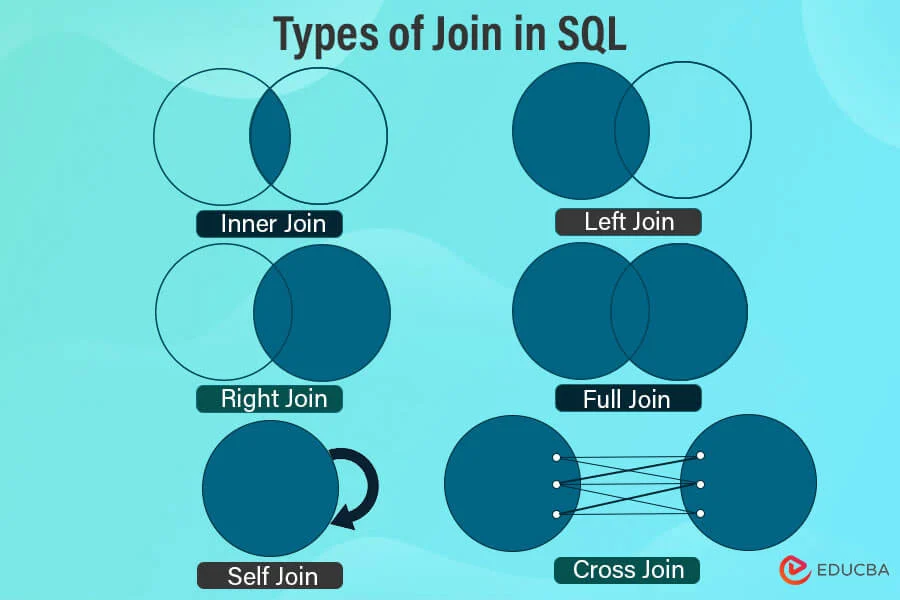

*Cross join - Every combination of both DataFrames.*

In [1]:
# imports

from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [2]:
# Initialize Spark Session
spark = SparkSession.builder.appName("DataManipulation").getOrCreate()

# Read from file
data_path = '/kaggle/input/pubg-finish-placement-prediction/train_V2.csv'
df = spark.read.csv(data_path, header=True, inferSchema=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/28 19:23:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
df.columns

['Id',
 'groupId',
 'matchId',
 'assists',
 'boosts',
 'damageDealt',
 'DBNOs',
 'headshotKills',
 'heals',
 'killPlace',
 'killPoints',
 'kills',
 'killStreaks',
 'longestKill',
 'matchDuration',
 'matchType',
 'maxPlace',
 'numGroups',
 'rankPoints',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired',
 'winPoints',
 'winPlacePerc']

In [36]:
df.select(
    percentile('heals', [0.99])
    ).show()

+---------------------------------+
|percentile(heals, array(0.99), 1)|
+---------------------------------+
|                           [12.0]|
+---------------------------------+



In [27]:
df.describe('heals').show()

+-------+------------------+
|summary|             heals|
+-------+------------------+
|  count|           4446966|
|   mean| 1.370147196987789|
| stddev|2.6799822305289855|
|    min|                 0|
|    max|                80|
+-------+------------------+



In [69]:
df.filter('heals > 12 AND damageDealt > 100') \
    .select('DamageDealt', 'heals', 'winPoints') \
    .groupBy('winPoints') \
    .agg(
        sum('DamageDealt').alias('DMG'),
        sum('heals')
    ) \
    .orderBy('winPoints', ascending=False) \
    .show()

+---------+------+----------+
|winPoints|   DMG|sum(heals)|
+---------+------+----------+
|     2002| 632.9|        20|
|     1990| 179.3|        15|
|     1958| 306.1|        22|
|     1953| 391.7|        16|
|     1929| 393.7|        13|
|     1928| 419.9|        15|
|     1920| 146.8|        32|
|     1905| 534.6|        15|
|     1902| 823.4|        26|
|     1901| 584.8|        15|
|     1899| 125.4|        14|
|     1892|1187.0|        13|
|     1890| 385.2|        14|
|     1887| 131.1|        13|
|     1886| 545.4|        24|
|     1885| 763.3|        15|
|     1879| 592.9|        19|
|     1873| 205.2|        15|
|     1872| 576.9|        14|
|     1871| 799.2|        23|
+---------+------+----------+
only showing top 20 rows



## window

In [ ]:
# Define window specification
window_spec = Window.partitionBy("winPoints").orderBy(col('damageDealt'))

# Add rankings
df_window = (
    df.withColumn("rank", rank().over(window_spec))               # skips next rank (number) after tie [1,2,2,4]
      .withColumn("row_number", row_number().over(window_spec))   # don't skips next rank (number) after tie [1,2,2,3]
      .withColumn("dense_rank", dense_rank().over(window_spec))   # every rank is unique [1,2,3,4]
)

# Running totals
window_sum = Window.partitionBy("winPoints").orderBy("damageDealt").rowsBetween(Window.unboundedPreceding, Window.currentRow) # gives cumulative sum of every previous record
df_rows = df.withColumn("running_total", sum("damageDealt").over(window_sum))

df_window.sort(desc('winPoints')).show()
df_rows.sort(desc('winPoints')).show()

In [ ]:
# without "rowsBetween" we got only sum of current row, so basicy values from our column
df_window.withColumn('sum_all', sum('damageDealt').over(window_spec)) \
    .sort(desc('WinPoints')).show()

+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+---------+---------------+------------+---------------+---------+------------+----+----------+----------+------------------+
|            Id|       groupId|       matchId|assists|boosts|damageDealt|DBNOs|headshotKills|heals|killPlace|killPoints|kills|killStreaks|longestKill|matchDuration|matchType|maxPlace|numGroups|rankPoints|revives|rideDistance|roadKills|swimDistance|teamKills|vehicleDestroys|walkDistance|weaponsAcquired|winPoints|winPlacePerc|rank|row_number|dense_rank|           sum_all|
+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+------

## Joins

In [ ]:
df_1, df_2 = df.randomSplit([0.4, 0.6])

inner_join = df_1.join(df_2, df_1.groupId == df_2.groupId, 'inner')
inner_join.show()

## Data transformation

In [34]:
df_sample = df.sample(fraction=0.1)
df_sample.withColumn("Killers_ranking",
                      when(col('kills') <= 0, 'n00b') \
                      .when((col('kills') > 0) & (col('kills') < 10), 'gamer') \
                      .when(col('kills') > 10, 'Pro')
).show(5)

+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+---------+---------------+------------+---------------+---------+------------+---------------+
|            Id|       groupId|       matchId|assists|boosts|damageDealt|DBNOs|headshotKills|heals|killPlace|killPoints|kills|killStreaks|longestKill|matchDuration|matchType|maxPlace|numGroups|rankPoints|revives|rideDistance|roadKills|swimDistance|teamKills|vehicleDestroys|walkDistance|weaponsAcquired|winPoints|winPlacePerc|Killers_ranking|
+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+---------+---------------+------------+---------------+---------+-

# General Machine learning concepts

## Metrics

| Metric                   |                                What it measures | Range & quick interpretation                 | When to report / quick example                                                            |
| ------------------------ | ----------------------------------------------: | -------------------------------------------- | ----------------------------------------------------------------------------------------- |
| **Accuracy**             |         Overall fraction of correct predictions | 0 → 1. Higher = better.                      | Quick baseline; only reliable when classes are balanced.                                  |
| **Precision**            |    Of predicted positives, how many are correct | 0 → 1. High → few false positives            | Use when false alarms are costly (e.g., spam filter precision).                           |
| **Recall (Sensitivity)** |          Of true positives, how many were found | 0 → 1. High → few misses                     | Use when missing positives is costly (e.g., medical screening).                           |
| **F1 score**             |            Balance between precision and recall | 0 → 1. Higher = better balance               | Use when you want a single number trading off precision vs recall (imbalanced tasks).     |
| **ROC AUC**              | How well the model ranks positives vs negatives | 0 → 1. 0.5 = random; higher = better ranking | Useful for overall ranking performance across thresholds (common in many DL/image tasks). |

* Thresholding: Classification metrics except ROC AUC depend on the decision threshold. If you report precision/recall/F1, state the threshold or report curves.

* Imbalanced data: Don’t rely on accuracy. Prefer precision/recall/F1 and per-class reporting. For very rare positives, use PR analysis in addition to ROC AUC.


| Metric                                        |                                            What it communicates |                                                                  Units / range |                            Sensitivity to outliers | When to report / quick example                                                                                    |
| --------------------------------------------- | --------------------------------------------------------------: | -----------------------------------------------------------------------------: | -------------------------------------------------: | ----------------------------------------------------------------------------------------------------------------- |
| **MAE (Mean Absolute Error)**                 | Average absolute prediction error (typical magnitude of errors) |                                                   Same units as target (0 → ∞) |           **Robust** (less affected by big errors) | Use when you want an interpretable average error (e.g., “avg delivery time error = 3.2 min”).                     |
| **RMSE (Root MSE)**                           |         Root of average squared error — emphasizes large errors |                                                   Same units as target (0 → ∞) | **Sensitive** to outliers (penalizes large misses) | Use when large errors are particularly bad (e.g., peak demand forecasting). Report with MAE for context.          |
| **R² (coefficient of determination)**         |           Fraction of variance in target explained by the model | Unitless. 1 = perfect; 0 = same as predicting mean; negative = worse than mean |          Not an error metric; insensitive to units | Use as a quick goodness-of-fit check (e.g., R² = 0.72 → explains 72% of variance).                                |
| **MAPE (Mean Absolute % Error)** *(optional)* |                   Average percent error relative to true values |                                                             % (watch when y≈0) |       Problematic with zeros or very small targets | Useful for business KPIs reported in percent (e.g., forecasting sales), but use carefully when targets near zero. |  

## Regularization

**What?:**   

**Regularization** is a set of techniques that impose additional constraints or penalties on model parameters during training. Its goal is to prevent overfitting by discouraging overly complex models and encouraging simpler ones.

**Why?:**
- Control Overfitting: Models with too many parameters can fit noise in the training data, leading to poor generalization on new data.

- Bias–Variance Trade‑Off: Regularization adds a bit of bias (via penalty) to reduce variance, often lowering total error on unseen data.

- Feature Selection & Interpretability: Some methods (e.g. Lasso) set redundant feature coefficients to zero, effectively selecting a subset of predictors.

**How?:**  

1. Choose a Penalty Term Incorporate into loss: Regularized Loss = Data Loss + **𝜆** × Penalty ​
2. Standardize Features Ensure all predictors are on comparable scales (zero mean, unit variance). 
3. Select Regularization Strength **(λ)** Tune via cross‑validation (e.g., grid search over **λ** values). 
4. Train & Validate Fit model on training set; evaluate on validation set to pick the best **λ**. 
5. Retrain on Full Data Once **λ** is chosen, retrain using combined training + validation data before final testing.

**Examples:**  

| Method             | How It Works                                                                    | Use Cases                                         | Pros & Cons                                                                                                   |
| ------------------ | ------------------------------------------------------------------------------- | ------------------------------------------------- | ------------------------------------------------------------------------------------------------------------- |
| **Ridge (L2)**          | Adds a penalty proportional to the square of coefficient magnitudes *(adds a stronger penalty for large coefficients)*             | When predictors are multicollinear                | • Pros: Stabilizes estimates; keeps all features<br>• Cons: No feature selection                              |
| **Lasso (L1)**          | Adds a penalty proportional to the absolute value of coefficients               | Feature selection in high‐dimensional data        | • Pros: Drives some coefficients exactly to zero<br>• Cons: Can be unstable if features are highly correlated |
| **Elastic Net**    | Blends Ridge (L2) and Lasso (L1) penalties via a mixing parameter α             | Correlated features, very high dimensions         | • Pros: Balances shrinkage and sparsity<br>• Cons: Requires tuning two hyperparameters (λ and α)              |
| **Group Lasso**    | Applies Lasso‐style penalty to predefined groups of features simultaneously     | When features naturally form groups               | • Pros: Entire groups can be excluded<br>• Cons: Needs correct grouping a priori                              |
| **Dropout**        | Randomly “drops” (zeros out) a fraction of units during neural network training | Deep learning, especially large nets              | • Pros: Simple to implement; reduces co‑adaptation<br>• Cons: Slows training convergence                      |
| **Early Stopping** | Halts training once validation error stops improving                            | Any iterative training (e.g. boosting, deep nets) | • Pros: No extra penalty term; easy to monitor<br>• Cons: Requires a held‑out validation set                  |
| **Weight Decay**   | Equivalent to applying an L2 penalty on network weights during backpropagation  | Neural networks in most DL frameworks             | • Pros: Built into many libraries; smooths weight updates<br>• Cons: Similar behavior to Ridge, no sparsity   |


## Central Limit Theorem
**Key Idea**:  
If you take many random samples from any population and compute their means, the distribution of those means will be approximately normal and similiar to the mean of the population (as long as the sample size is large enough (usually ≥ 30).)

## Bagging/Boosting

**Bagging**: Asking 10 friends the same question and taking the average of their answers. Each friend sees a slightly different version of the question.

**Boosting**: Single friend learning from their mistakes over time—each time they get feedback, they improve their answer.

| Feature                     | 🧺 Bagging                          | 🚀 Boosting                          |
|----------------------------|------------------------------------|-------------------------------------|
| **Goal**                   | Reduce **variance**                | Reduce **bias**                     |
| **Model Training**         | Models trained **independently**   | Models trained **sequentially**     |
| **Data Sampling**          | Random subsets with **replacement** | Focus on **misclassified** samples  |
| **Model Weighting**        | All models have **equal weight**   | Models are **weighted by accuracy** |
| **Error Handling**         | Averages predictions to smooth noise | Learns from **previous errors**     |
| **Overfitting Risk**       | Lower (good for noisy data)        | Higher (needs careful tuning)       |
| **Popular Algorithms**     | Random Forest                      | AdaBoost, Gradient Boosting, XGBoost|
| **Best For**               | High-variance models               | High-bias models                    |


## Self-Supervised Models

Definition: Models trained without manual labels. They learn patterns or representations directly from raw data.

**Idea**: Create a pretext task (e.g., predict masked parts of an image or next words in text) so the model teaches itself.

Example:

- In vision: Masked Autoencoders (MAE) reconstruct missing image patches.

- In NLP: BERT predicts masked words.

**Benefit**: Reduces labeling costs and creates strong representations for downstream tasks.

| Method / Group                      | Core Idea                                                                     | Benchmark-Proven Examples                                                                             | Practical Visualization / Example                                                                                                       | Pros ✅                                                                                                                                    | Cons ❌                                                                                     |
| ----------------------------------- | ----------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------ |
| **Contrastive Learning**            | Learn by **pulling positive pairs together** and **pushing negatives apart**. | • **SimCLR** (vision) <br>• **MoCo v3** (vision) <br>• **CLIP** (image–text)                          | Two augmented views of the same cat photo are positives 🐱↔🐱, a dog photo is a negative 🐶. The model learns “catness” without labels. | • Excellent representation quality <br>• State-of-the-art transfer to classification/detection <br>• Works across modalities (e.g., CLIP) | • Needs large batches or memory banks <br>• Sensitive to augmentations                     |
| **Masked / Reconstruction Methods** | Mask part of the input and **reconstruct** it.                                | • **BERT** (masked words) <br>• **MAE** (masked image patches) <br>• **ViT-based masked pretraining** | Hide 75% of an image of a car 🚗, force the model to fill in missing patches—teaches global structure.                                  | • Simple objectives <br>• Great for transformers <br>• Scales extremely well with data                                                    | • May emphasize low-level details rather than semantics if masking strategy is poor        |
| **Clustering / Prototypical**       | Group features into clusters, train to predict cluster assignments.           | • **SwAV** (online clustering with contrastive signals)                                               | Mix shuffled crops of the same street scene 🌆, assign them to the same cluster—model groups similar scenes without labels.             | • No need for explicit negatives <br>• Strong performance with moderate compute                                                           | • Hyperparameter sensitive <br>• Slightly behind contrastive/MAE in some recent benchmarks |